In [18]:
############################ PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations, product
import pyreadr
import seaborn as sns
import copy

import tensorflow as tf
import tensorflow_lattice as tfl
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding, Activation
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from keras.optimizers.legacy import Adam, Nadam, RMSprop
from keras.models import clone_model
import keras_tuner as kt
from keras import backend as K
from keras import regularizers
from keras.utils import plot_model
from keras.losses import Poisson, Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError

# import xgboost as xgb
from scipy.stats import uniform, randint
from pygam import PoissonGAM, GAM, s, f, l, te # s for spline, f for factor, l for linear, te for tensor product
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer
from interpret.glassbox import ExplainableBoostingRegressor
import joblib

import warnings
warnings.filterwarnings('ignore') # suprress warnings

In [19]:
#-------------------------- for reproducibility --------------------------
seed_value = 2000
keras.utils.set_random_seed(seed_value)
np.random.seed(seed_value)

In [20]:
#-------------------------- import data --------------------------
''' Belgian motor third-party liability dataset from the CAS collection '''
r_data = pyreadr.read_r("data/beMTPL97.rda")
data = r_data['beMTPL97']
data.head() # view data snapshot

,id,expo,claim,nclaims,amount,average,coverage,ageph,sex,bm,power,agec,fuel,use,fleet,postcode,long,lat
0,1,1.000000,1,1,1618.001036,1618.001036,TPL,50,male,5,77,12,gasoline,private,0,1000,4.355223,50.845386
1,2,1.000000,0,0,0.000000,NaN,TPL+,64,female,5,66,3,gasoline,private,0,1000,4.355223,50.845386
2,3,1.000000,0,0,0.000000,NaN,TPL,60,male,0,70,10,diesel,private,0,1000,4.355223,50.845386
3,4,1.000000,0,0,0.000000,NaN,TPL,77,male,0,57,15,gasoline,private,0,1000,4.355223,50.845386
4,5,0.046575,1,1,155.974606,155.974606,TPL,28,female,9,70,7,gasoline,private,0,1000,4.355223,50.845386


In [21]:
############################ DATA UNDERSTANDING & CLEANING ############################

#-------------------------- high-level checking --------------------------
print(data.shape) # number of rows and columns
print(data.info()) # check data type and missing values

(163212, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163212 entries, 0 to 163211
Data columns (total 18 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   id        163212 non-null  int32   
 1   expo      163212 non-null  float64 
 2   claim     163212 non-null  category
 3   nclaims   163212 non-null  int32   
 4   amount    163212 non-null  float64 
 5   average   18276 non-null   float64 
 6   coverage  163212 non-null  category
 7   ageph     163212 non-null  int32   
 8   sex       163212 non-null  category
 9   bm        163212 non-null  int32   
 10  power     163212 non-null  int32   
 11  agec      163212 non-null  int32   
 12  fuel      163212 non-null  category
 13  use       163212 non-null  category
 14  fleet     163212 non-null  category
 15  postcode  163212 non-null  int32   
 16  long      163212 non-null  float64 
 17  lat       163212 non-null  float64 
dtypes: category(6), float64(5), int32(7)
memory usage: 

In [22]:
#-------------------------- filter claim data --------------------------
claim = data.drop(columns = ["id","claim","amount","average","postcode"]).reset_index(drop = True) # filter positive claims and remove unnecessary columns
print(f"{claim.shape[0]} rows and {claim.shape[1]} columns")
claim.head()

163212 rows and 13 columns


,expo,nclaims,coverage,ageph,sex,bm,power,agec,fuel,use,fleet,long,lat
0,1.000000,1,TPL,50,male,5,77,12,gasoline,private,0,4.355223,50.845386
1,1.000000,0,TPL+,64,female,5,66,3,gasoline,private,0,4.355223,50.845386
2,1.000000,0,TPL,60,male,0,70,10,diesel,private,0,4.355223,50.845386
3,1.000000,0,TPL,77,male,0,57,15,gasoline,private,0,4.355223,50.845386
4,0.046575,1,TPL,28,female,9,70,7,gasoline,private,0,4.355223,50.845386


In [23]:
#-------------------------- descriptive statistics for numeric columns --------------------------
claim[["expo","nclaims","ageph","bm","power","agec","long","lat"]].describe()

,expo,nclaims,ageph,bm,power,agec,long,lat
count,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000
mean,0.889744,0.123857,47.000950,3.268246,56.002978,7.374923,4.407262,50.758422
std,0.244202,0.367471,14.831561,3.998171,19.024828,4.206447,0.751036,0.317856
min,0.002740,0.000000,18.000000,0.000000,10.000000,0.000000,2.577787,49.536246
25%,1.000000,0.000000,35.000000,0.000000,43.000000,4.000000,3.879313,50.516333
50%,1.000000,0.000000,46.000000,1.000000,53.000000,7.000000,4.387146,50.771932
75%,1.000000,0.000000,58.000000,6.000000,66.000000,10.000000,4.874195,50.994654
max,1.000000,5.000000,95.000000,22.000000,243.000000,48.000000,6.305543,51.449816


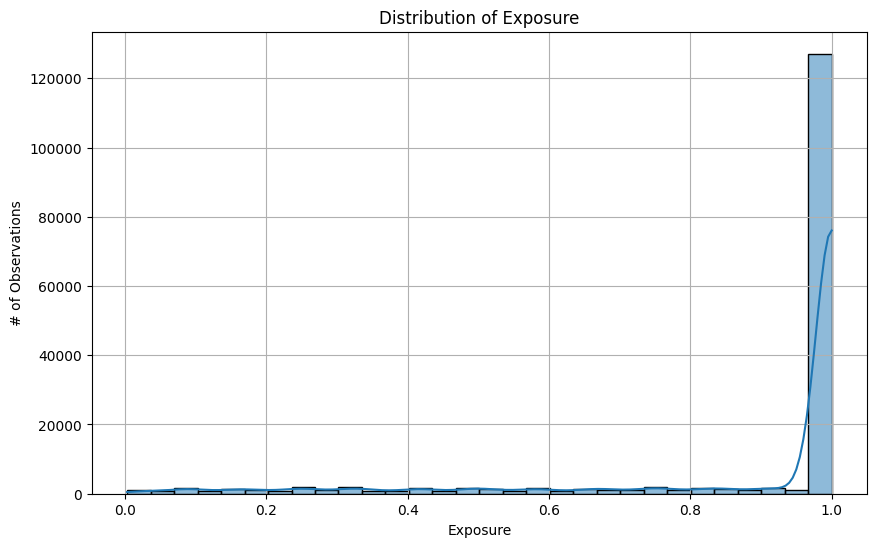

In [24]:
#-------------------------- distribution of claim amount --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.histplot(claim['expo'], bins = 30, kde = True) # draw the chart
plt.title('Distribution of Exposure')
plt.xlabel('Exposure')
plt.ylabel('# of Observations')
plt.grid(True)
plt.show()

In [25]:
### function to get the summary of number of instances per distinct category for categorical variable
def get_summary(data, column):
    summary = data[column].value_counts().reset_index()
    summary.columns = [column, 'Count']
    return summary

In [26]:
#-------------------------- check the distribution of categorical variables --------------------------
# get the categorical variables
cat_vars = ["coverage", "sex", "fuel", "use", "fleet"]
num_vars = ["ageph", "bm", "power", "agec", "long", "lat"] # numerical variables
all_vars = ["expo"] + cat_vars + num_vars

# get the distributions of categorical and target variables
summary_tables = {}
for column in ["nclaims"] + cat_vars:
    summary = get_summary(claim, column)
    summary_tables[column] = summary

# display the summary tables
for column, summary in summary_tables.items():
    print(f"{column} Summary:\n", summary, "\n")

nclaims Summary:
    nclaims   Count
0        0  144936
1        1   16539
2        2    1556
3        3     162
4        4      17
5        5       2 

coverage Summary:
   coverage  Count
0      TPL  95124
1     TPL+  45984
2    TPL++  22104 

sex Summary:
       sex   Count
0    male  120044
1  female   43168 

fuel Summary:
        fuel   Count
0  gasoline  112818
1    diesel   50394 

use Summary:
        use   Count
0  private  155334
1     work    7878 

fleet Summary:
   fleet   Count
0     0  158041
1     1    5171 



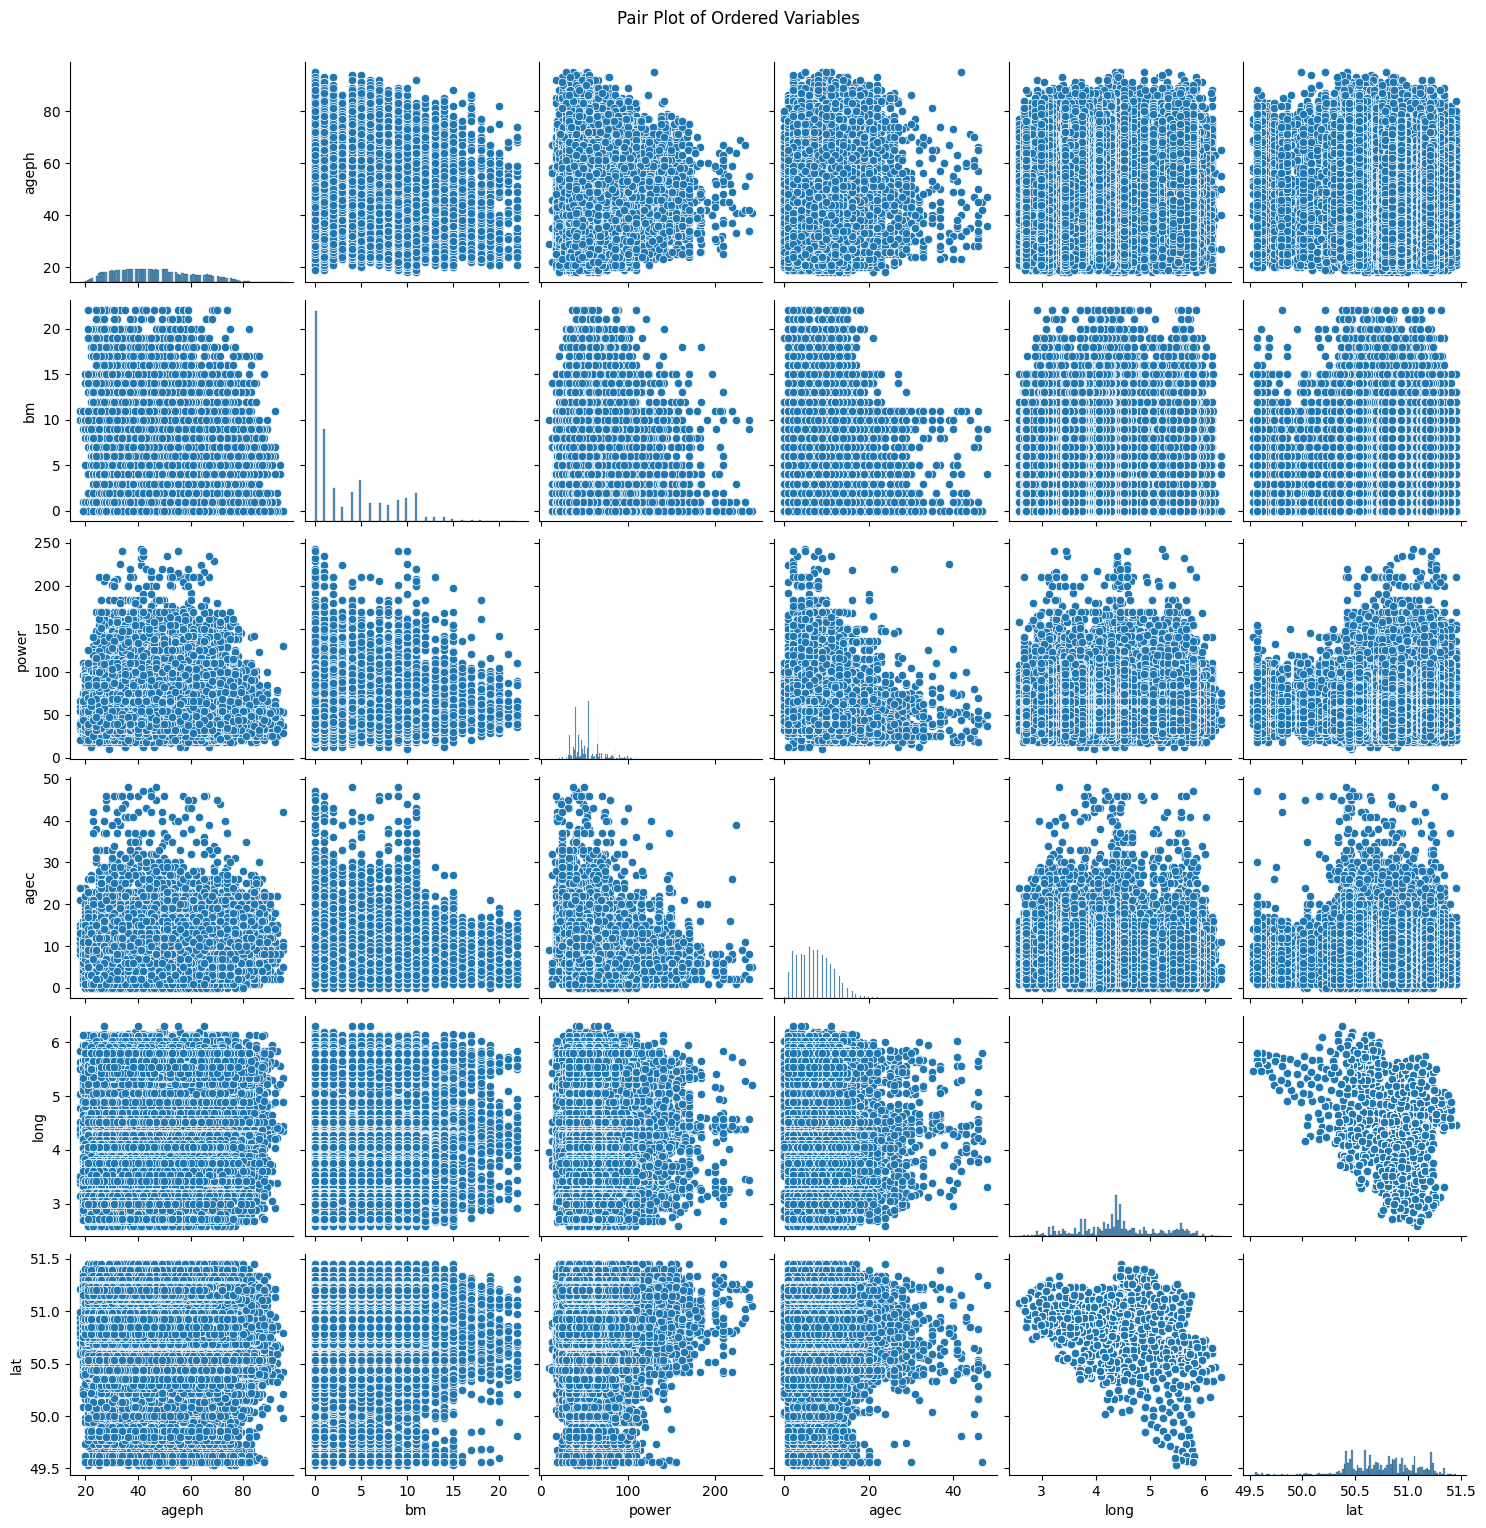

In [27]:
# -------------------------- check distribution of continuous and ordinal variables --------------------------
# Create pair plots for the specified variables
sns.pairplot(claim[num_vars])
plt.suptitle('Pair Plot of Ordered Variables', y = 1.02)
plt.show()

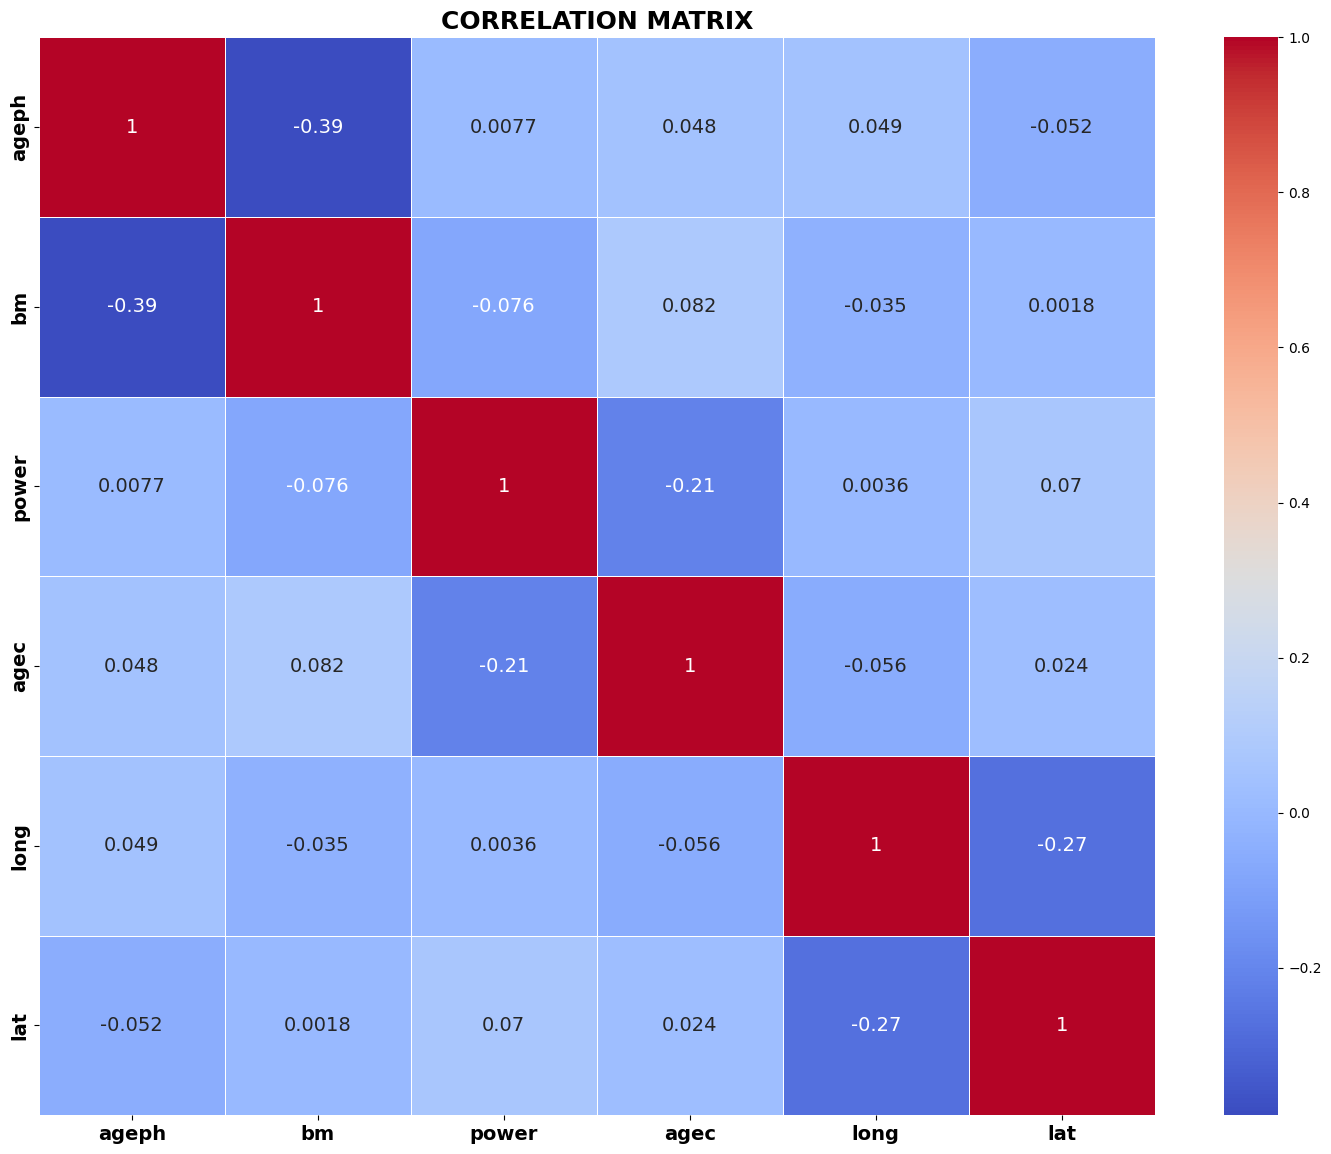

In [28]:
#-------------------------- check correlations of numeric variables --------------------------
correlation_matrix = claim[num_vars].corr() # correlation matrix

# plot the heatmap
plt.figure(figsize = (18, 14))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', linewidths = 0.5, annot_kws = {"size":14})
plt.title('CORRELATION MATRIX', fontsize = 18, fontweight = 'bold')
plt.xticks(fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 14, fontweight = 'bold')
plt.show()

In [29]:
#-------------------------- train-test split --------------------------
target_var = "nclaims"
X_main, X_test, y_main, y_test = train_test_split(
    claim[all_vars], claim[target_var], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [30]:
#-------------------------- variable encoding --------------------------
# define transformer
ct = make_column_transformer(
    ("passthrough", ["expo"]),
    (OrdinalEncoder(), cat_vars),
    remainder = StandardScaler(),
    verbose_feature_names_out = False
)

# fit & transform
train = ct.fit_transform(X_train)
val = ct.fit_transform(X_val)
test = ct.transform(X_test)
feature_names = ct.get_feature_names_out()  # get the columns' names
feature_names

array(['expo', 'coverage', 'sex', 'fuel', 'use', 'fleet', 'ageph', 'bm',
       'power', 'agec', 'long', 'lat'], dtype=object)

In [31]:
############################ NEURAL ADDITIVE MODEL ############################

# -------------------------- create custom layer and subnetwork --------------------------
# subnetwork for numerical variables
def create_subnet(num_layers, units_first_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for i in range(num_layers):
        num_units = units_first_layer - i*int(units_first_layer/num_layers)
        model.add(Dense(num_units, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(BatchNormalization(scale = False)) # for identifiability
    return model

# layer to add all subnets' outputs and a bias term
@keras.saving.register_keras_serializable()
class AddSubnetOutput(Layer):
    def __init__(self, activation = None, **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.bias = self.add_weight(
            shape = (1,), initializer = 'zeros', trainable = True, name = 'bias'
        )   
    def call(self, inputs):
        subnet_sum = K.sum(inputs, axis = -1, keepdims = True)
        output = subnet_sum + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

# helper function to add calibrator layer
def add_calibrate_layer(var, other_var, data, monotonicity_list, lattice_sizes, keypoints, cat_vars, all_vars, lattice_smooth_reg = [0,0]):
    if var in cat_vars:
        calibrator_layer = tfl.layers.CategoricalCalibration(
            num_buckets = np.unique(data[:,all_vars.index(var)]).size,
            output_min = 0,
            output_max = lattice_sizes[var] - 1,
            name = f"{var}_calibrator_pairwise_{var}_{other_var}"
        )
    else:
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(data[:,all_vars.index(var)].min(), data[:,all_vars.index(var)].max(), num = keypoints), # keypoints
            kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
            monotonicity = monotonicity_list[var] if var in monotonicity_list else "none", # monotonicity constraint
            output_min = 0,
            output_max = lattice_sizes[var] - 1,
            name = f"{var}_calibrator_pairwise_{var}_{other_var}"
            )
    return calibrator_layer

In [32]:
# -------------------------- custom constraint--------------------------
# function to add smoothness penalty
def make_smoothness_penalty(var, data, model, lambd_smooth, grid_length, imp_vars, all_vars):
    # Create input grid as TensorFlow tensors
    grid_min = tf.constant(data[:,all_vars.index(var)].min(), dtype = tf.float32)
    grid_max = tf.constant(data[:,all_vars.index(var)].max(), dtype = tf.float32)
    grid = tf.linspace(grid_min, grid_max, grid_length)
    grid = tf.reshape(grid, (-1, 1))  # Ensure grid is a column vector

    # Prepare inputs for the model
    grid_inputs = []
    for feature in imp_vars:
        if feature == var:
            grid_inputs.append(grid)
        else:
            # Use zeros_like to match the shape of grid
            grid_inputs.append(tf.zeros_like(grid))

    # Define a zero-argument function to compute the penalty
    def smoothness_penalty():
        # Get the prediction
        f = model(grid_inputs)[:, imp_vars.index(var) - 1]
        f = tf.reshape(f, (-1,))  # Flatten to 1D tensor for slicing

        # Calculate the second derivative using finite differences
        h = (grid_max - grid_min) / (grid_length - 1)
        h_squared = h ** 2
        f_plus = f[2:]      # f(x + h)
        f_minus = f[:-2]    # f(x - h)
        f_current = f[1:-1] # f(x)

        # Second derivative approximation
        second_derivative = (f_plus + f_minus - 2 * f_current) / h_squared

        # Compute the penalty
        penalty = lambd_smooth * K.mean(tf.abs(second_derivative))
        return penalty
    
    return smoothness_penalty

In [33]:
#-------------------------- prepare the data for NAM --------------------------
X_train_split = []
X_val_split = []
for i in range(train.shape[1]):
    X_train_split.append(train[:, i])
    X_val_split.append(val[:, i])

In [34]:
# -------------------------- Fit an ensemble of 10 NAMs --------------------------
seed = 0
num_models = 10
all_variance = []

# create ensemble and get subnet variance
for i in range(num_models):
    
    keras.utils.set_random_seed(seed)

    # -------------------------- hyperparameters --------------------------
    inputs = []  # input layers
    sub_outputs_main = []  # main effect subnet output
    num_neurons_main = 20
    num_layers_main = 2
    activation = 'leaky_relu'
    keypoints = 10
    monotonicity_list = {"bm" : "increasing"} # either "increasing", "decreasing", or "none"


    # -------------------------- model architecture --------------------------
    # main effect
    for name in all_vars:
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)

        # subnetworks for main effects
        if name == "expo":  # Direct use without a subnet
            exposure_input = input_layer
        elif name in cat_vars: # categorical variables
            # categorical variables will be one-hot encoded
            embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                    output_dim = 1, 
                                    name = f"{name}_embed")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
            sub_outputs_main.append(mean_layer)
        elif name in monotonicity_list: # variables with monotonicity constraint
            calibrator_layer = tfl.layers.PWLCalibration(
                input_keypoints =  np.linspace(train[:,all_vars.index(name)].min(), train[:,all_vars.index(name)].max(), num = keypoints), # keypoints
                monotonicity = monotonicity_list[name], # monotonicity constraint
                name = f"{name}_pwlcalibrator"
            )(input_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
            sub_outputs_main.append(mean_layer)
        else: # numeric variables
            subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
            sub_output = subnet(input_layer)
            sub_outputs_main.append(sub_output)

    # combine subnets' outputs
    main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
    sum_output = AddSubnetOutput(activation = 'exponential',
                        name = "main_output")(main_subnets) # claim frequency per unit of exposure
    final_output = Multiply(name = "final_output")([exposure_input, sum_output])

    # model
    model_all_vars = Model(inputs = inputs, outputs = final_output)


    # -------------------------- fit the model --------------------------
    model_all_vars.compile(optimizer = "rmsprop", loss = "poisson", metrics = ["poisson", RootMeanSquaredError(), MeanAbsoluteError()])
    es = EarlyStopping(restore_best_weights = True, patience = 10)
    model_all_vars.fit(X_train_split, y_train, epochs = 5_000, \
        callbacks = [es], batch_size = 5_000, validation_data = (X_val_split, y_val), verbose = 0)
    

    # -------------------------- quantify variable importance --------------------------
    main_output_layer = model_all_vars.get_layer("main_subnet")  # Get the subnet output layer
    main_model = Model(inputs = model_all_vars.inputs, outputs = main_output_layer.output)
    main_output_values = main_model.predict(X_train_split, batch_size = 5_000)

    # Get the variance of each subnetwork across all data points
    subnet_variance = [np.var(main_output_values[:, i]) for i in range(main_output_values.shape[1])]
    all_variance.append(subnet_variance)

    # update seed
    seed += 1

20/20 [==============================] - 0s 2ms/step


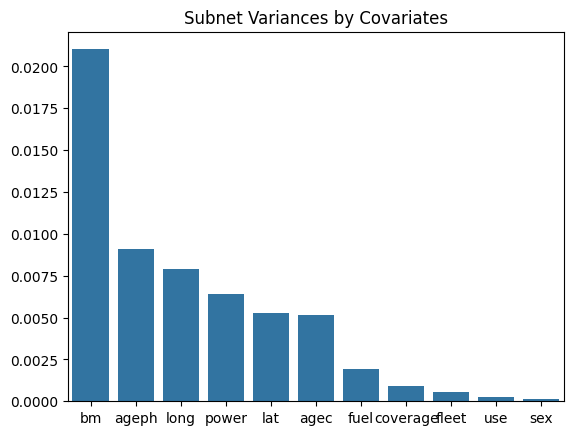

In [35]:
# -------------------------- plot the variable importance --------------------------
average_variances = np.mean(all_variance, axis = 0) # get the average variance
covariates = [name for name in cat_vars + num_vars] # get variable name

# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": average_variances})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
# plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variances by Covariates")
plt.xlabel("")
plt.ylabel("")

plt.rcParams["figure.figsize"] = (12, 4) # (for square figures)
plt.rcParams["figure.dpi"] = 350
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.show()

In [36]:
#-------------------------- reset keras seed --------------------------
keras.utils.set_random_seed(seed_value)

In [37]:
#-------------------------- main effect model --------------------------
inputs = []  # input layers
sub_outputs_main = []  # main effect subnet output
num_neurons_main = 20
num_layers_main = 2
activation = 'leaky_relu'
keypoints = 10
monotonicity_list = {"bm" : "increasing"} # either "increasing", "decreasing", or "none"
imp_vars = ["ageph", "bm", "power", "lat", "long", "fuel", "agec"]

# main effect
for name in ["expo"] + imp_vars:
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    # subnetworks for main effects
    if name == "expo":  # Direct use without a subnet
        exposure_input = input_layer
    elif name in cat_vars: # categorical variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                output_dim = 1, 
                                name = f"{name}_embed")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
        mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
        sub_outputs_main.append(mean_layer)
    elif name in monotonicity_list: # variables with monotonicity constraint
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(train[:,all_vars.index(name)].min(), train[:,all_vars.index(name)].max(), num = keypoints), # keypoints
            monotonicity = monotonicity_list[name], # monotonicity constraint
            name = f"{name}_pwlcalibrator"
        )(input_layer)
        mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
        sub_outputs_main.append(mean_layer)
    else: # numeric variables
        subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        sub_outputs_main.append(sub_output)

# combine subnets' outputs
main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
sum_output = AddSubnetOutput(activation = 'exponential',
                    name = "main_effect_sum")(main_subnets) # claim frequency per unit of exposure
final_output = Multiply(name = "main_effect_output")([exposure_input, sum_output])

# model
model_main_effect = Model(inputs = inputs, outputs = final_output)

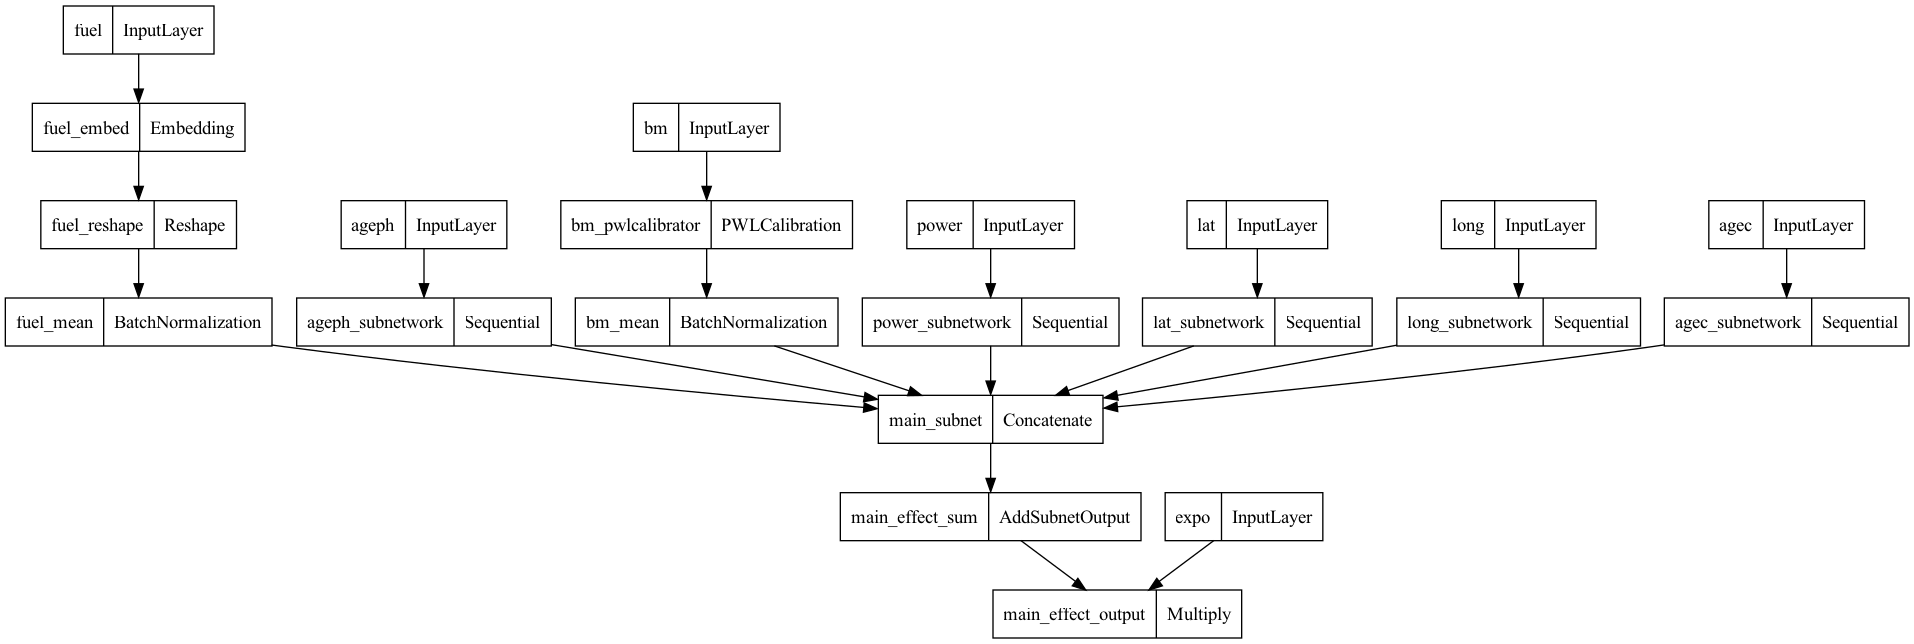

In [38]:
plot_model(model_main_effect)

In [39]:
#-------------------------- data preparation --------------------------
X_train_split = []
X_val_split = []
X_test_split = []
for var in ["expo"] + imp_vars:
    X_train_split.append(train[:, all_vars.index(var)])
    X_val_split.append(val[:, all_vars.index(var)])
    X_test_split.append(test[:, all_vars.index(var)])

In [40]:
# #-------------------------- fit NAM with only important main effects --------------------------
model_main_effect.compile(optimizer = "rmsprop", loss = "poisson")
es = EarlyStopping(restore_best_weights = True, patience = 20)
model_main_effect.fit(X_train_split, y_train, epochs = 5_000, \
    callbacks = [es], batch_size = 5_000, validation_data = (X_val_split, y_val))

Epoch 1/5000
20/20 [==============================] - 2s 14ms/step - loss: 3.4578 - val_loss: 0.6088
Epoch 2/5000
20/20 [==============================] - 0s 5ms/step - loss: 1.7324 - val_loss: 0.6077
Epoch 3/5000
20/20 [==============================] - 0s 5ms/step - loss: 1.2285 - val_loss: 0.6028
Epoch 4/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.9301 - val_loss: 0.5869
Epoch 5/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.6707 - val_loss: 0.5332
Epoch 6/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.5795 - val_loss: 0.4837
Epoch 7/5000
20/20 [==============================] - 0s 7ms/step - loss: 0.5302 - val_loss: 0.4482
Epoch 8/5000
20/20 [==============================] - 0s 7ms/step - loss: 0.4881 - val_loss: 0.4285
Epoch 9/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.4617 - val_loss: 0.4070
Epoch 10/5000
20/20 [==============================] - 0s 7ms/step - loss: 0.4331 - val_loss: 0.394

In [41]:
# -------------------------- get validation loss --------------------------
main_val_loss = model_main_effect.evaluate(X_val_split, y_val, verbose = False) # get the validation loss and RMSE
print(f"Validation loss for main effect: {main_val_loss}")

Validation loss for main effect: 0.372553288936615


In [42]:
#-------------------------- preparation for interaction selection --------------------------
global_layers = ["main_subnet", "main_effect_sum", "main_effect_output", "interaction_output", "final_output"] # these layers are always trainable
num_layers_interaction = 10 # number of layers for each interaction effect
num_neurons_interaction = 100 # number of neurons per dense layer for each interaction effect
keypoints = 20
interactions = combinations(imp_vars, 2)
interaction_loss = {} # this stores the validation loss when fitting each pair of interaction effect
lattice_sizes_pairwise = {}
for var in imp_vars:
    if var in cat_vars:
        lattice_sizes_pairwise[var] = X_train[var].nunique()
    else:
        lattice_sizes_pairwise[var] = 8

In [43]:
#-------------------------- select interaction effect --------------------------
for var1, var2 in interactions:

    # -------------------------- initialize a cloned model --------------------------
    model_main_cloned = clone_model(model_main_effect) # clone the main effect model
    model_main_cloned.build(model_main_effect.input_shape)
    model_main_cloned.set_weights(model_main_effect.get_weights()) # copy the weights


    # -------------------------- build a subnet for pairwise interaction effect --------------------------
    var1_input = model_main_cloned.inputs[imp_vars.index(var1) + 1]
    var2_input = model_main_cloned.inputs[imp_vars.index(var2) + 1]

    # Lattice model if the pair contains a monotonic variable
    if any(var in monotonicity_list for var in [var1, var2]):
        lattice_inputs = []

        # create calibrator_layer
        calibrator_var1 = add_calibrate_layer(var1, var2, train, monotonicity_list, lattice_sizes_pairwise, keypoints, cat_vars, all_vars)
        calibrator_var2 = add_calibrate_layer(var2, var1, train, monotonicity_list, lattice_sizes_pairwise, keypoints, cat_vars, all_vars)
        calibrator_layer_var1 = calibrator_var1(var1_input)
        calibrator_layer_var2 = calibrator_var2(var2_input)
        
        # lattice
        lattice_inputs.append(calibrator_layer_var1)
        lattice_inputs.append(calibrator_layer_var2)
        lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes_pairwise[var1],lattice_sizes_pairwise[var2]], 
                            monotonicities = ["increasing" if var1 in monotonicity_list else 'none',
                                                "increasing" if var2 in monotonicity_list else 'none'],
                            name = f"{var1}_{var2}_lattice")(lattice_inputs)
        pairwise_output = BatchNormalization(scale = False, name = f"{var1}_{var2}_mean")(lattice_layer)
    else:
        # Subnetwork if the pair contains no monotonic variables
        pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
        pairwise_subnet = create_subnet(num_layers_interaction, 
                                        num_neurons_interaction, 
                                        activation, 
                                        f"{var1}_{var2}_subnetwork")
        pairwise_output = pairwise_subnet(pairwise_input_layer)

    # final output
    interaction_subnet_output = Activation('exponential',
                        name = "interaction_output")(pairwise_output)
    main_subnet_output = model_main_cloned.output
    final_output = Multiply(name = "final_output")([main_subnet_output, interaction_subnet_output])
    model_pairwise = Model(inputs = model_main_cloned.inputs, outputs = final_output)


    # -------------------------- switch on/off layers --------------------------
    for layer in model_pairwise.layers:
        if layer.name not in global_layers and var1 not in layer.name and var2 not in layer.name:
            layer.trainable = False


    # -------------------------- compile and train the model --------------------------
    model_pairwise.compile(optimizer = 'adam', 
                        loss = "poisson")
    es = EarlyStopping(patience = 20, restore_best_weights = True)
    model_pairwise.fit(X_train_split, y_train, epochs = 5_000, \
                            callbacks = [es], batch_size = 5_000, validation_data = (X_val_split, y_val))
    val_loss = model_pairwise.evaluate(X_val_split, y_val, batch_size = 5_000)
    interaction_loss[f"{var1}_{var2}"] = val_loss # add to the val loss list

Epoch 1/5000
20/20 [==============================] - 1s 17ms/step - loss: 0.4525 - val_loss: 0.3798
Epoch 2/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.4174 - val_loss: 0.3781
Epoch 3/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.4096 - val_loss: 0.3844
Epoch 4/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.4049 - val_loss: 0.3833
Epoch 5/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.4017 - val_loss: 0.3857
Epoch 6/5000
20/20 [==============================] - 0s 7ms/step - loss: 0.3988 - val_loss: 0.3818
Epoch 7/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.3963 - val_loss: 0.3847
Epoch 8/5000
20/20 [==============================] - 0s 7ms/step - loss: 0.3934 - val_loss: 0.3820
Epoch 9/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.3909 - val_loss: 0.3883
Epoch 10/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.3880 - val_loss: 0.389

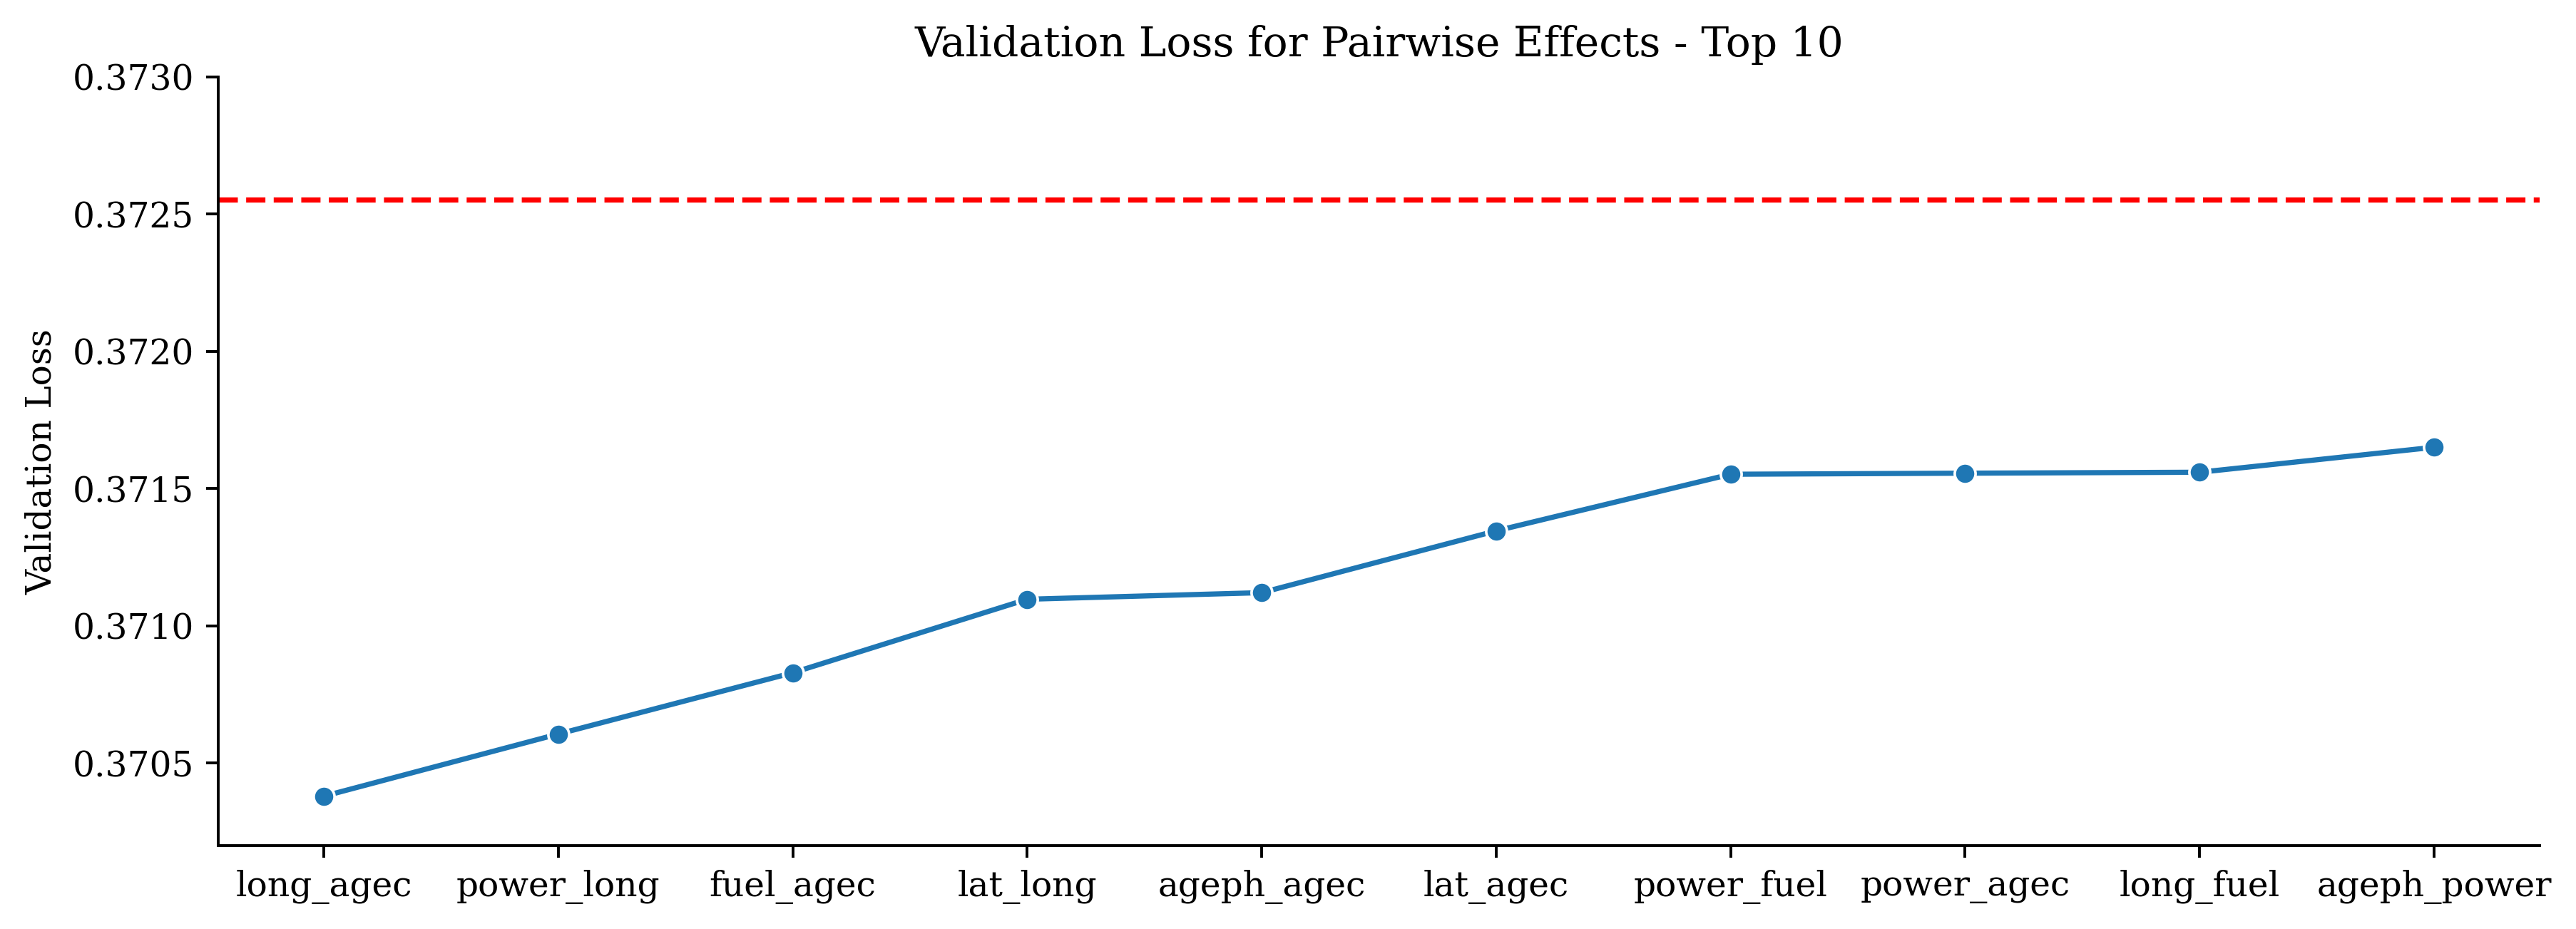

In [44]:
# -------------------------- plot the validation loss --------------------------
# Convert interaction loss dictionary to a pandas DataFrame
interaction_df = pd.DataFrame(list(interaction_loss.items()), columns = ['Interaction_Pair', 'Validation_Loss'])

# Sort the DataFrame by Validation_Loss in increasing order
interaction_df = interaction_df.sort_values(by = 'Validation_Loss', ascending = True)
interaction_df = interaction_df.head(10) # select the top 10 effects

# Create the bar plot using Seaborn
# plt.figure(figsize = (28, 12))
sns.lineplot(x = 'Interaction_Pair', y = 'Validation_Loss', data = interaction_df, marker = 'o')
plt.axhline(main_val_loss, color = 'red', linestyle = '--')
plt.xlabel('')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Pairwise Effects - Top 10')
# plt.legend()

plt.rcParams["figure.figsize"] = (12, 4) # (for square figures)
plt.rcParams["figure.dpi"] = 350
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.ylim(0.3702, 0.373)

plt.show()

In [45]:
# -------------------------- define model architecture --------------------------
def build_NAM(hp):

    # -------------------- hyperpameters --------------------
    smooth_vars = ["ageph","bm","power","lat","long","agec"]
    interactions = [("long","agec"),("power","long"),("fuel","agec"),("lat","long"),("ageph","agec")]
    inputs = []  # input layers
    sub_outputs = [] # subnet output
    lattice_sizes = {} # number of vertices for each variable's lattice
    monotonicity = {"bm": "increasing"} # either increasing, decreasing, or none
    grid_length = 1000 # for using finite differences with smoothness constraint
    activation = "leaky_relu"

    # hypeparameters for tuning
    num_neurons_main = hp.Int('num_neurons_main', 20, 80, step = 20) # number of neurons for main effects' subnets' hidden layers
    num_layers_main = hp.Int('num_layers_main', 2, 5) # number of hidden layers for main effects' subnets
    num_neurons_interaction = hp.Int('num_neurons_int', 20, 140, step = 20) # number of neurons for interaction effects' subnets' hidden layers
    num_layers_interaction = hp.Int('num_layers_int', 2, 10, step = 2) # number of hidden layers for interaction effects' subnets
    num_keypoints = hp.Int('num_keypoints', 20, 60, step = 10) # number of key points for lattice calibrator
    num_vertices = hp.Int('num_vertices', 2, 20, step = 4) # number of vertices for lattice layer
    lambd_mc = hp.Float('lambd_mc', min_value = 1e-5, max_value = 1e-2, sampling = 'log') # weight for marginal clarity constraint in objective function
    lambd_smooth = hp.Float('lambd_smoothness', min_value = 1e-5, max_value = 1e-1, sampling = 'log') # weight for smoothness constraint in objective function


    # add lattice size
    for var in imp_vars:
        if var in cat_vars:
            lattice_sizes[var] = X_train[var].nunique()
        else:
            lattice_sizes[var] = num_vertices


    # -------------------- main effect --------------------
    for name in ["expo"] + imp_vars:
        # input layer
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)

        # subnetwork
        if name == "expo": # Direct use without a subnet
            exposure_input = input_layer
        elif name in cat_vars: # categorical variables will be one-hot encoded
            embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                    output_dim = 1, 
                                    name = f"{name}_embed")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
            sub_outputs.append(mean_layer)
        elif name in monotonicity: # variables with monotonicity constraint
            calibrator_layer = tfl.layers.PWLCalibration(
                input_keypoints =  np.linspace(train[:,all_vars.index(name)].min(), train[:,all_vars.index(name)].max(), num = num_keypoints), # keypoints
                monotonicity = monotonicity[name], # monotonicity constraint
                name = f"{name}_pwlcalibrator"
            )(input_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
            sub_outputs.append(mean_layer)
        else: # numeric variables
            subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)


    # -------------------- pairwise interaction effect --------------------
    for (var1, var2) in interactions:
        var1_input = inputs[imp_vars.index(var1) + 1]
        var2_input = inputs[imp_vars.index(var2) + 1]

        if any(var in monotonicity for var in [var1, var2]):
            lattice_inputs = []

            # calibrator layer
            calibrator_var1 = add_calibrate_layer(var1, var2, train, monotonicity, lattice_sizes, num_keypoints, cat_vars, all_vars)
            calibrator_var2 = add_calibrate_layer(var2, var1, train, monotonicity, lattice_sizes, num_keypoints, cat_vars, all_vars)
            calibrator_layer_var1 = calibrator_var1(var1_input)
            calibrator_layer_var2 = calibrator_var2(var2_input)
            
            # lattice layer
            lattice_inputs.append(calibrator_layer_var1)
            lattice_inputs.append(calibrator_layer_var2)
            lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes[var1], lattice_sizes[var2]], 
                                                monotonicities = ["increasing" if var1 in monotonicity else 'none',
                                                                "increasing" if var2 in monotonicity else 'none'],
                                                name = f"{var1}_{var2}_lattice")(lattice_inputs)
            pairwise_output = BatchNormalization(scale = False, name = f"{var1}_{var2}_mean")(lattice_layer)
            sub_outputs.append(pairwise_output)

        else: # if no monotonicity constraint is required, create a normal subnetwork
            pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
            pairwise_subnet = create_subnet(num_layers_interaction, 
                                            num_neurons_interaction, 
                                            activation, 
                                            f"{var1}_{var2}_subnetwork")
            pairwise_dense = pairwise_subnet(pairwise_input_layer)
            sub_outputs.append(pairwise_dense)
        

    # -------------------- combine main and interaction effects --------------------
    # combine subnets' outputs
    main_subnets = Concatenate(name = "subnet_output")(sub_outputs)
    sum_output = AddSubnetOutput(activation = 'exponential',
                                    name = "sum_output")(main_subnets)
    final_output = Multiply(name = "final_output")([exposure_input, sum_output])
    model = Model(inputs = inputs, outputs = final_output)


    #-------------------------- add smoothness penalty --------------------------
    subnet_model = Model(inputs = model.inputs, outputs = main_subnets)
    for var in smooth_vars:
        penalty_function = make_smoothness_penalty(var, train, subnet_model, lambd_smooth, grid_length, ["expo"] + imp_vars, all_vars)
        model.add_loss(penalty_function)


    #-------------------------- add marginal clarity constraint --------------------------
    for i in range(len(interactions)):
        penalty = 0
        var1 = interactions[i][0]
        var2 = interactions[i][1]
        subnet_output = model.get_layer("subnet_output").output
        main_output_var1 = subnet_output[imp_vars.index(var1)]
        main_output_var2 = subnet_output[imp_vars.index(var2)]
        interaction_output = subnet_output[len(imp_vars) + i]
        penalty = lambd_mc * (
            K.abs(K.mean(main_output_var1 * interaction_output)) +
            K.abs(K.mean(main_output_var2 * interaction_output))
        )
        # Add the penalty to the model's total loss
        model.add_loss(penalty)


    #-------------------------- compile and return the model --------------------------
    model.compile(optimizer = "rmsprop", loss = "poisson", 
                    metrics = ["poisson", RootMeanSquaredError(), MeanAbsoluteError()])

    return model

In [46]:
# -------------------------- hyperparameters of final model --------------------------
# hyperparameter tuning
tuner_NAM = kt.tuners.BayesianOptimization(
    build_NAM,
    objective = kt.Objective('val_poisson', direction = 'min'),
    max_trials = 20,
    directory = "hyperparameter_beMTPL97_NAM",
    seed = 0 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 50, restore_best_weights = True)

# search for the best model
tuner_NAM.search(X_train_split, y_train,
            epochs = 5_000,
            batch_size = 10_000,
            validation_data = (X_val_split, y_val),
            callbacks = [es])

# get the best model
model_nam = tuner_NAM.get_best_models()[0]
tuner_NAM.results_summary(1)

Reloading Tuner from hyperparameter_beMTPL97_NAM/untitled_project/tuner0.json
Results summary
Results in hyperparameter_beMTPL97_NAM/untitled_project
Showing 1 best trials
Objective(name="val_poisson", direction="min")

Trial 08 summary
Hyperparameters:
num_neurons_main: 20
num_layers_main: 5
num_neurons_int: 20
num_layers_int: 10
num_keypoints: 50
num_vertices: 18
lambd_mc: 0.0004661941083582669
lambd_smoothness: 0.021221642702824103
Score: 0.3690630793571472


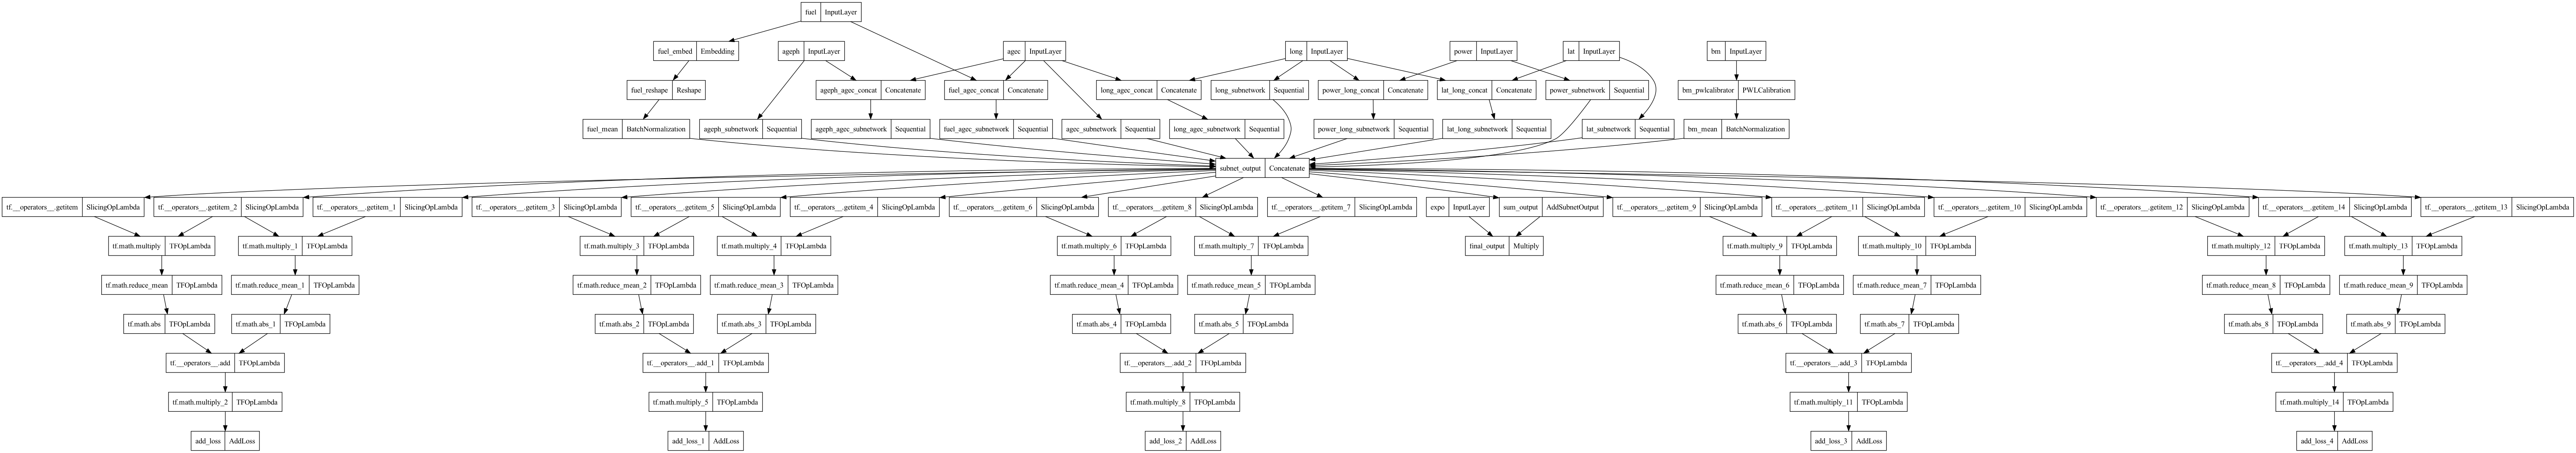

In [47]:
# plot themodel
plot_model(model_nam)

In [48]:
#-------------------------- evaluate predictive performance --------------------------
_, nam_nll, nam_rmse, nam_mae = model_nam.evaluate(X_test_split, y_test, batch_size = 5_000)
print(f"Poisson loss on test set: {nam_nll}")
print(f"RMSE on test set: {nam_rmse}")
print(f"MAE on test set: {nam_mae}")

7/7 [==============================] - 4s 10ms/step - loss: 0.4208 - poisson: 0.3786 - root_mean_squared_error: 0.3677 - mean_absolute_error: 0.2181
Poisson loss on test set: 0.3785819411277771
RMSE on test set: 0.36771541833877563
MAE on test set: 0.21812240779399872


1/1 [==============================] - 0s 408ms/step


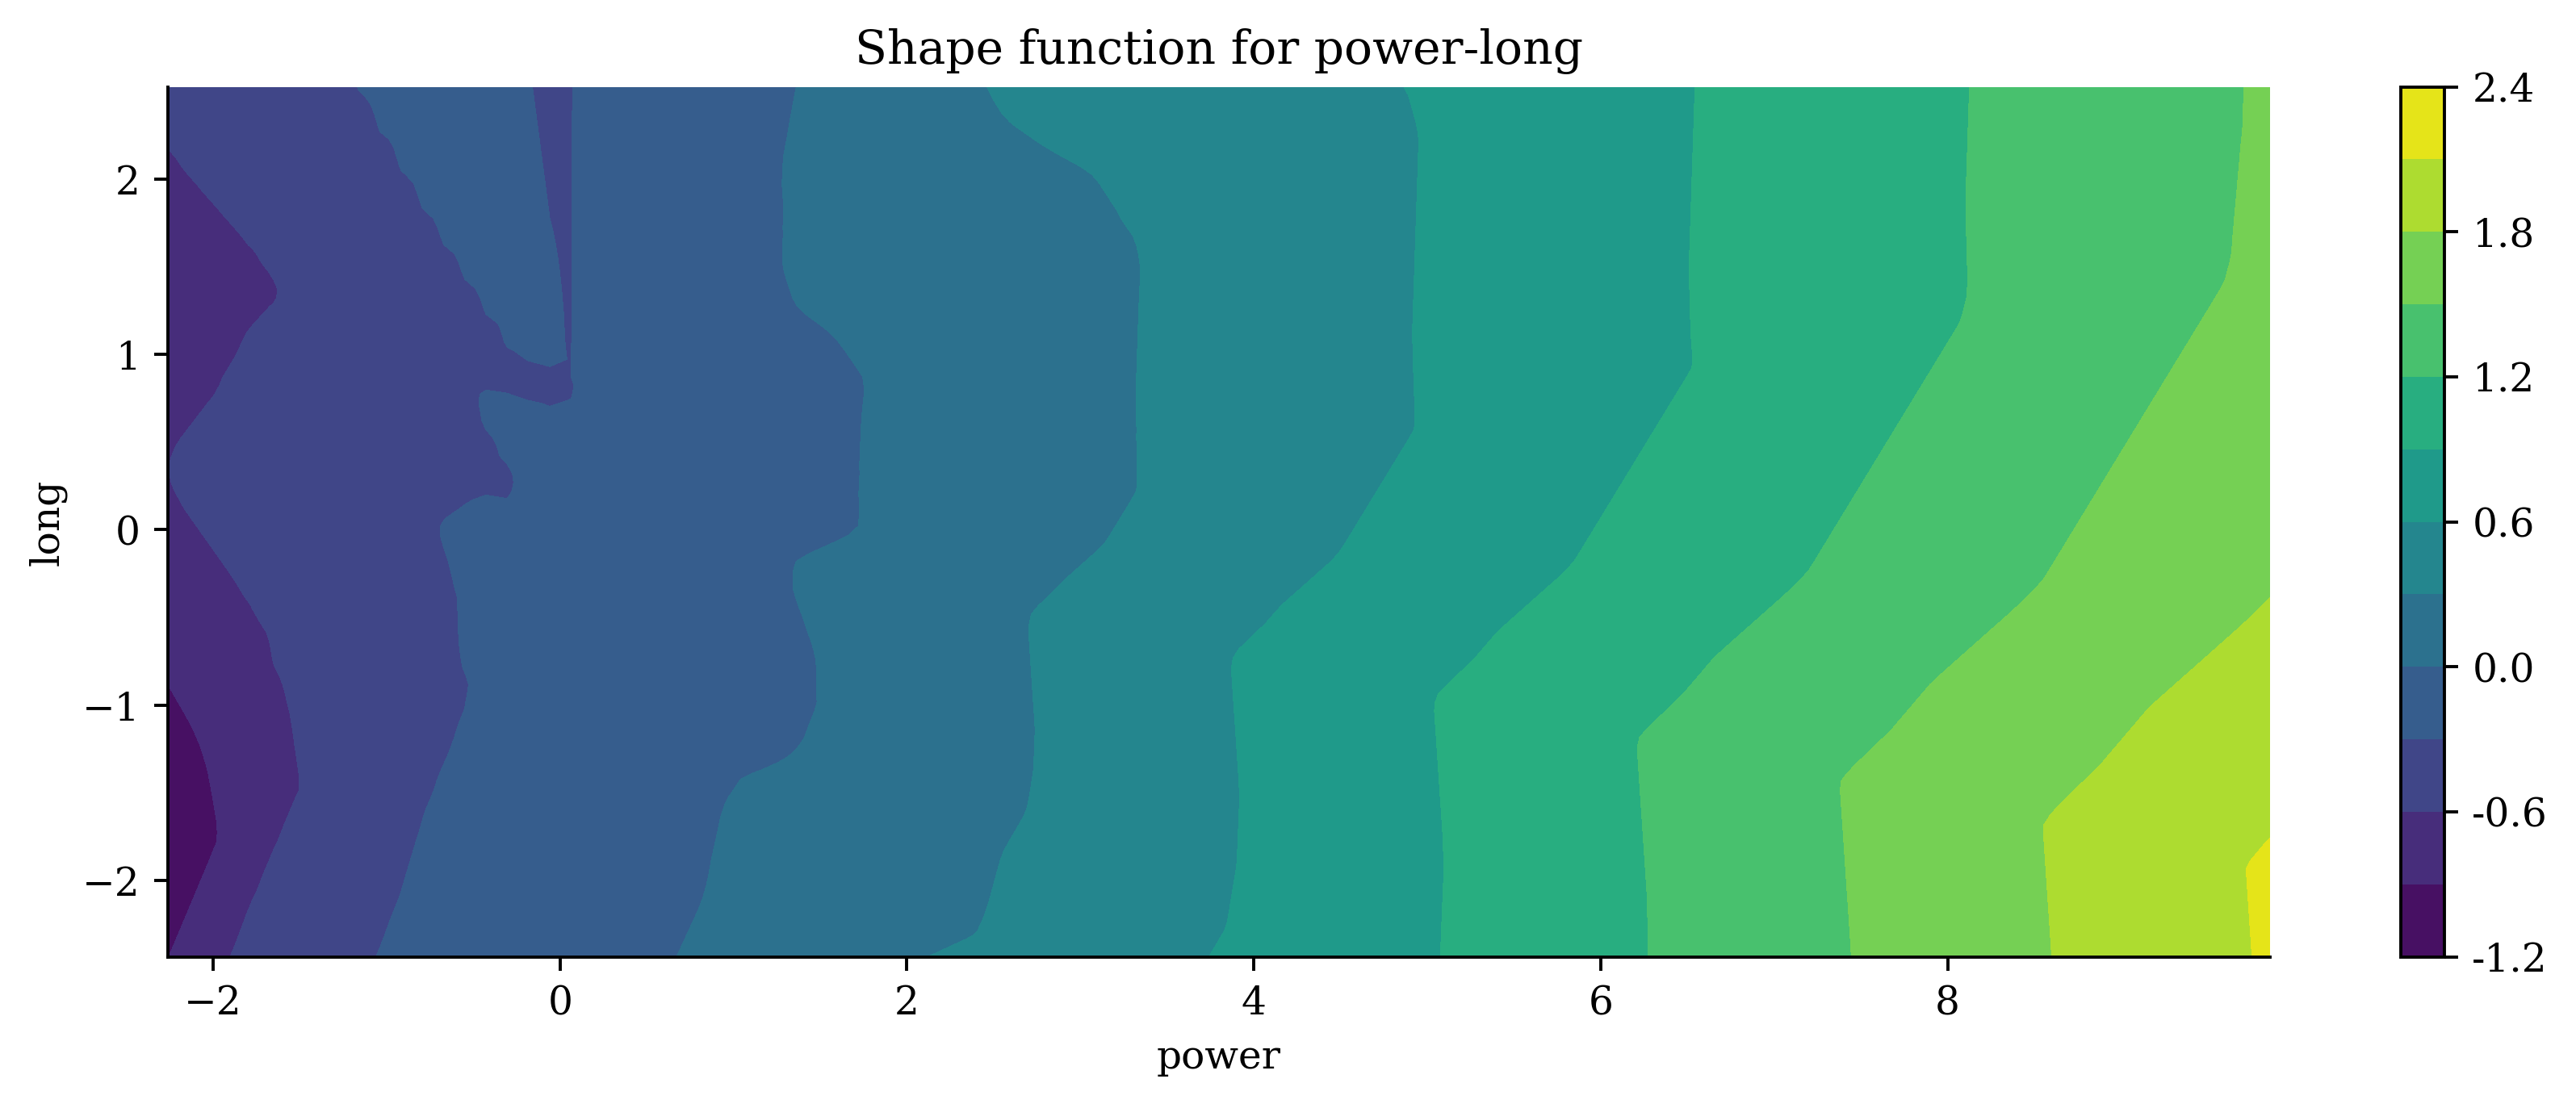

In [49]:
# -------------------------- Create the Pairwise Only Model --------------------------
interactions = [("long","agec"),("power","long"),("fuel","agec"),("lat","long"),("ageph","agec")]
pairwise_effect = ("power","long")  # the pairwise effect we want to view
pairwise_index = interactions.index(pairwise_effect)
subnet_output_layer = model_nam.get_layer("subnet_output")
subnet_model = Model(inputs = model_nam.inputs, outputs = subnet_output_layer.output)


# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 100
if pairwise_effect[0] in cat_vars:
    var1_values = np.unique(X_train_split[imp_vars.index(pairwise_effect[0]) + 1])
else:
    var1_values = np.linspace(np.min(X_train_split[imp_vars.index(pairwise_effect[0]) + 1]), 
                              np.max(X_train_split[imp_vars.index(pairwise_effect[0]) + 1]), 
                              grid_length)
if pairwise_effect[1] in cat_vars:
    var2_values = np.unique(X_train_split[imp_vars.index(pairwise_effect[1]) + 1])
else:
    var2_values = np.linspace(np.min(X_train_split[imp_vars.index(pairwise_effect[1]) + 1]), 
                              np.max(X_train_split[imp_vars.index(pairwise_effect[1]) + 1]), 
                              grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
for var in ["expo"] + imp_vars:
    if var == pairwise_effect[0]:
        grid_inputs.append(grid_flat_var1)
    elif var == pairwise_effect[1]:
        grid_inputs.append(grid_flat_var2)
    else:
        grid_inputs.append(np.zeros_like(grid_flat_var1))


# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
# main1_predictions = subnet_model.predict(grid_inputs, batch_size = 10_000)[:,imp_vars.index(pairwise_effect[0])]
# main2_predictions = subnet_model.predict(grid_inputs, batch_size = 10_000)[:,imp_vars.index(pairwise_effect[1])]
pairwise_predictions = subnet_model.predict(grid_inputs, batch_size = 10_000)[:,len(imp_vars) + pairwise_index]
# total_predictions = main1_predictions + main2_predictions + pairwise_predictions

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# -------------------------- Plot the Heatmap --------------------------
# plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10, cmap = "viridis")
plt.colorbar(contour, format="%.1f")
plt.title(f'Shape function for {pairwise_effect[0]}-{pairwise_effect[1]}')
plt.xlabel(f"{interactions[pairwise_index][0]}")
plt.ylabel(f"{interactions[pairwise_index][1]}")

plt.rcParams["figure.figsize"] = (4, 4) # (for square figures)
plt.rcParams["figure.dpi"] = 350
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.show()

1/1 [==============================] - 0s 16ms/step


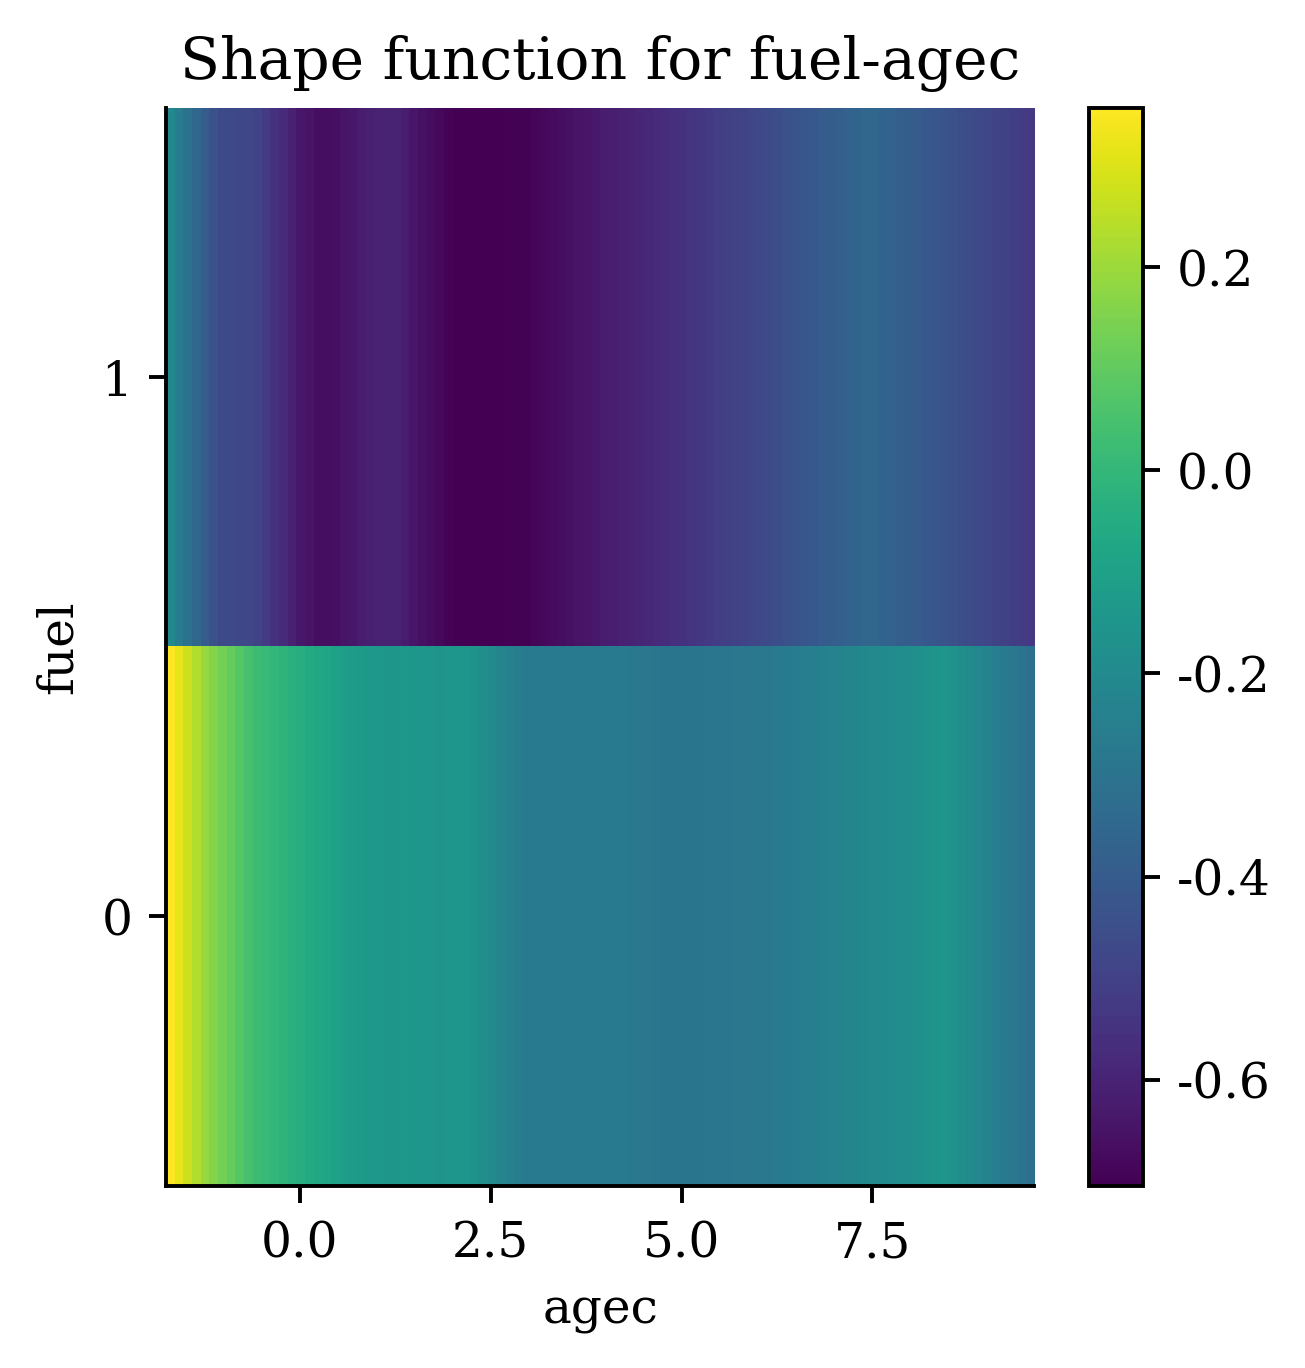

In [50]:
# -------------------------- Create the Pairwise Only Model --------------------------
interactions = [("long","agec"),("power","long"),("fuel","agec"),("lat","long"),("ageph","agec")]
pairwise_effect = ("fuel", "agec")  # the pairwise effect we want to view
pairwise_index = interactions.index(pairwise_effect)
subnet_output_layer = model_nam.get_layer("subnet_output")
subnet_model = Model(inputs=model_nam.inputs, outputs=subnet_output_layer.output)

# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values for `agec`
grid_length = 100
var2_values = np.linspace(np.min(X_train_split[imp_vars.index(pairwise_effect[1]) + 1]), 
                          np.max(X_train_split[imp_vars.index(pairwise_effect[1]) + 1]), 
                          grid_length)

# Generate inputs for `fuel = 0` and `fuel = 1`
grid_inputs_0 = []
grid_inputs_1 = []
for var in ["expo"] + imp_vars:
    if var == pairwise_effect[0]:  # fuel
        grid_inputs_0.append(np.zeros_like(var2_values))  # fuel = 0
        grid_inputs_1.append(np.ones_like(var2_values))   # fuel = 1
    elif var == pairwise_effect[1]:  # agec
        grid_inputs_0.append(var2_values)
        grid_inputs_1.append(var2_values)
    else:
        grid_inputs_0.append(np.zeros_like(var2_values))
        grid_inputs_1.append(np.zeros_like(var2_values))

# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect for `fuel = 0` and `fuel = 1`
pairwise_predictions_0 = subnet_model.predict(grid_inputs_0, batch_size=10_000)[:, len(imp_vars) + pairwise_index]
pairwise_predictions_1 = subnet_model.predict(grid_inputs_1, batch_size=10_000)[:, len(imp_vars) + pairwise_index]

# Combine predictions into a 2-row heatmap format (fuel = 0 and fuel = 1)
heatmap_values = np.vstack([pairwise_predictions_0, pairwise_predictions_1])

# -------------------------- Plot the Heatmap --------------------------
# plt.figure(figsize=(6, 4))
contour = plt.imshow(
    heatmap_values,
    aspect='auto',
    cmap='viridis',
    extent=[var2_values.min(), var2_values.max(), -0.5, 1.5],
    interpolation='none'  # Prevents grid lines due to interpolation
)
plt.colorbar(contour, format="%.1f")
plt.yticks([0, 1], ['0', '1'])
plt.title(f'Shape function for {pairwise_effect[0]}-{pairwise_effect[1]}')
plt.xlabel("agec")
plt.ylabel("fuel")

# Remove grid lines but keep axis labels
plt.grid(False)


plt.rcParams["figure.figsize"] = (4, 4)  # For square figures
plt.rcParams["figure.dpi"] = 350
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.show()


32/32 [==============================] - 0s 2ms/step


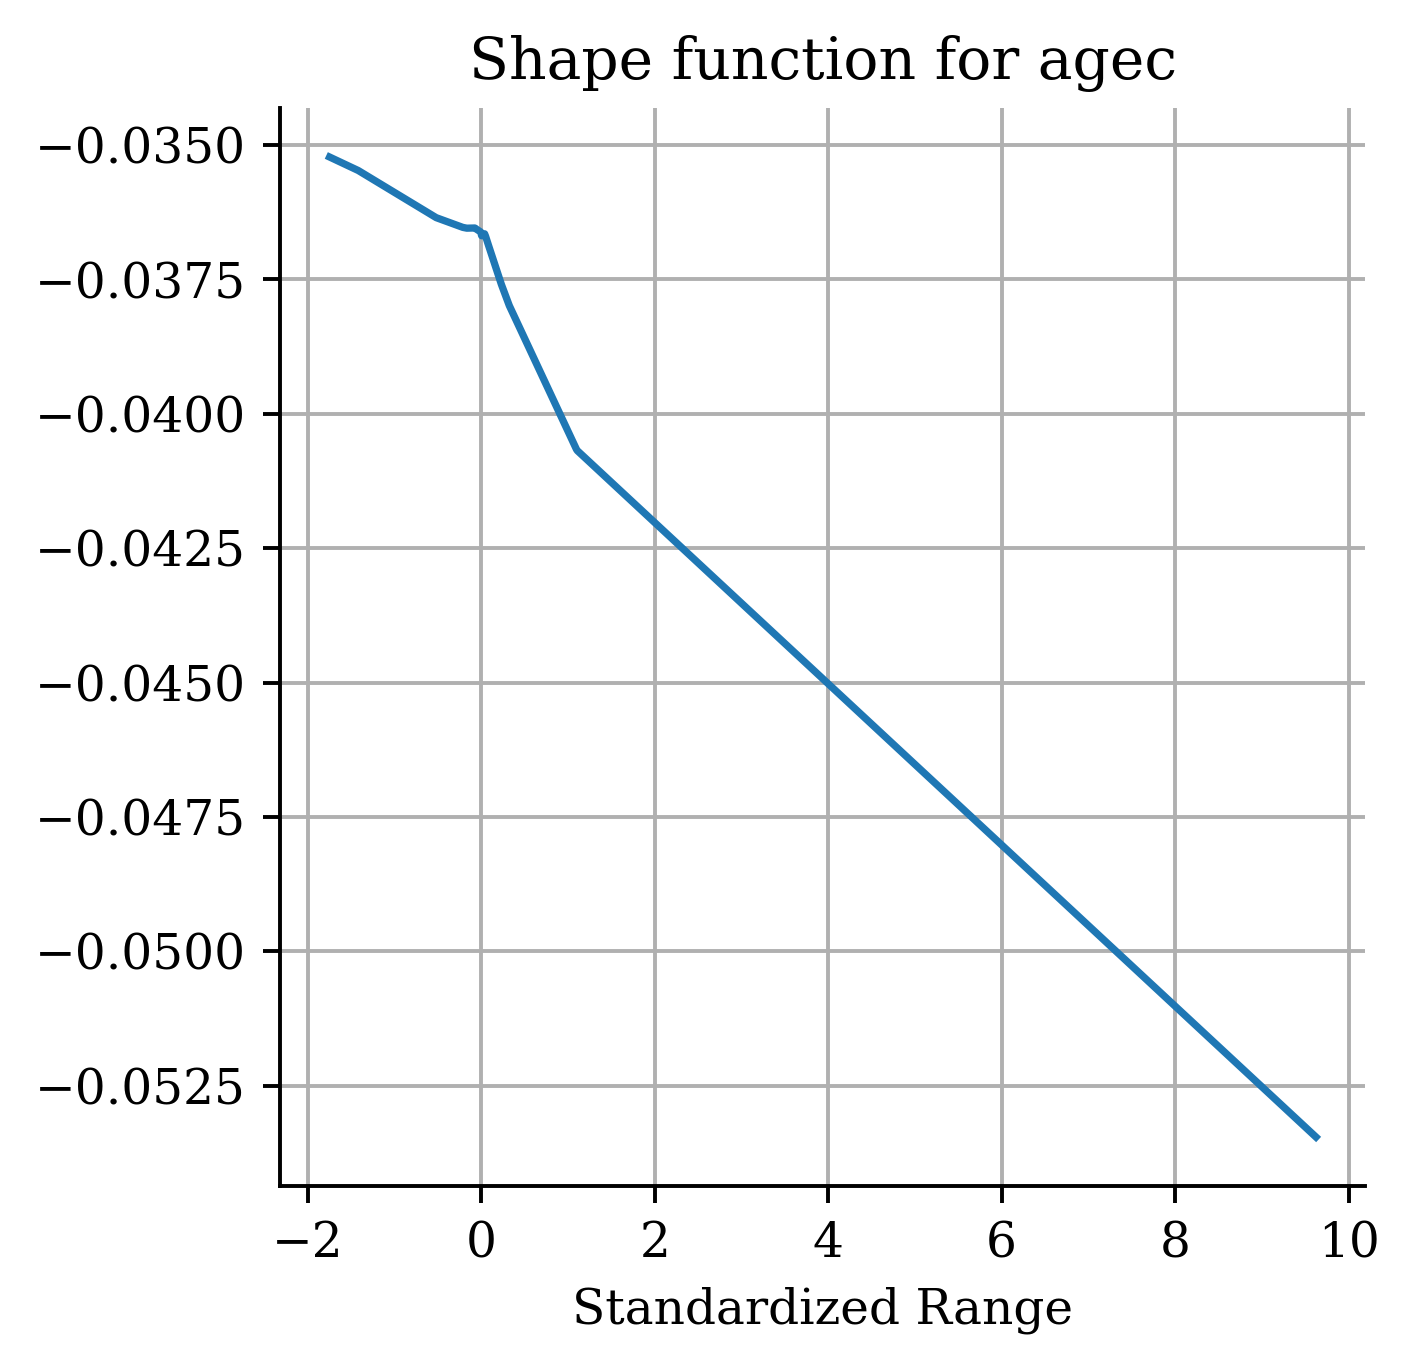

In [51]:
#-------------------------- view the shape function --------------------------
# create a grid
var_name = "agec"
var_index = imp_vars.index(var_name)
grid_length = 1000
grid_inputs = []
grid = np.linspace(np.min(X_train_split[imp_vars.index(var_name) + 1]), 
                   np.max(X_train_split[imp_vars.index(var_name) + 1]), 
                   grid_length)
for var in ["expo"] + imp_vars:
    if var == var_name:
        grid_inputs.append(grid)
    else:
        grid_inputs.append(np.zeros_like(grid))

# get the prediction
subnet_output = subnet_model.predict(grid_inputs)

# create the plot
# plt.figure(figsize = (12, 6))
sns.lineplot(x = grid, y = subnet_output[:,var_index])
plt.xlabel(f"Standardized Range")
# plt.ylabel('Subnetwork Output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)

plt.rcParams["figure.figsize"] = (4, 4) # (for square figures)
plt.rcParams["figure.dpi"] = 350
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.show()

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step


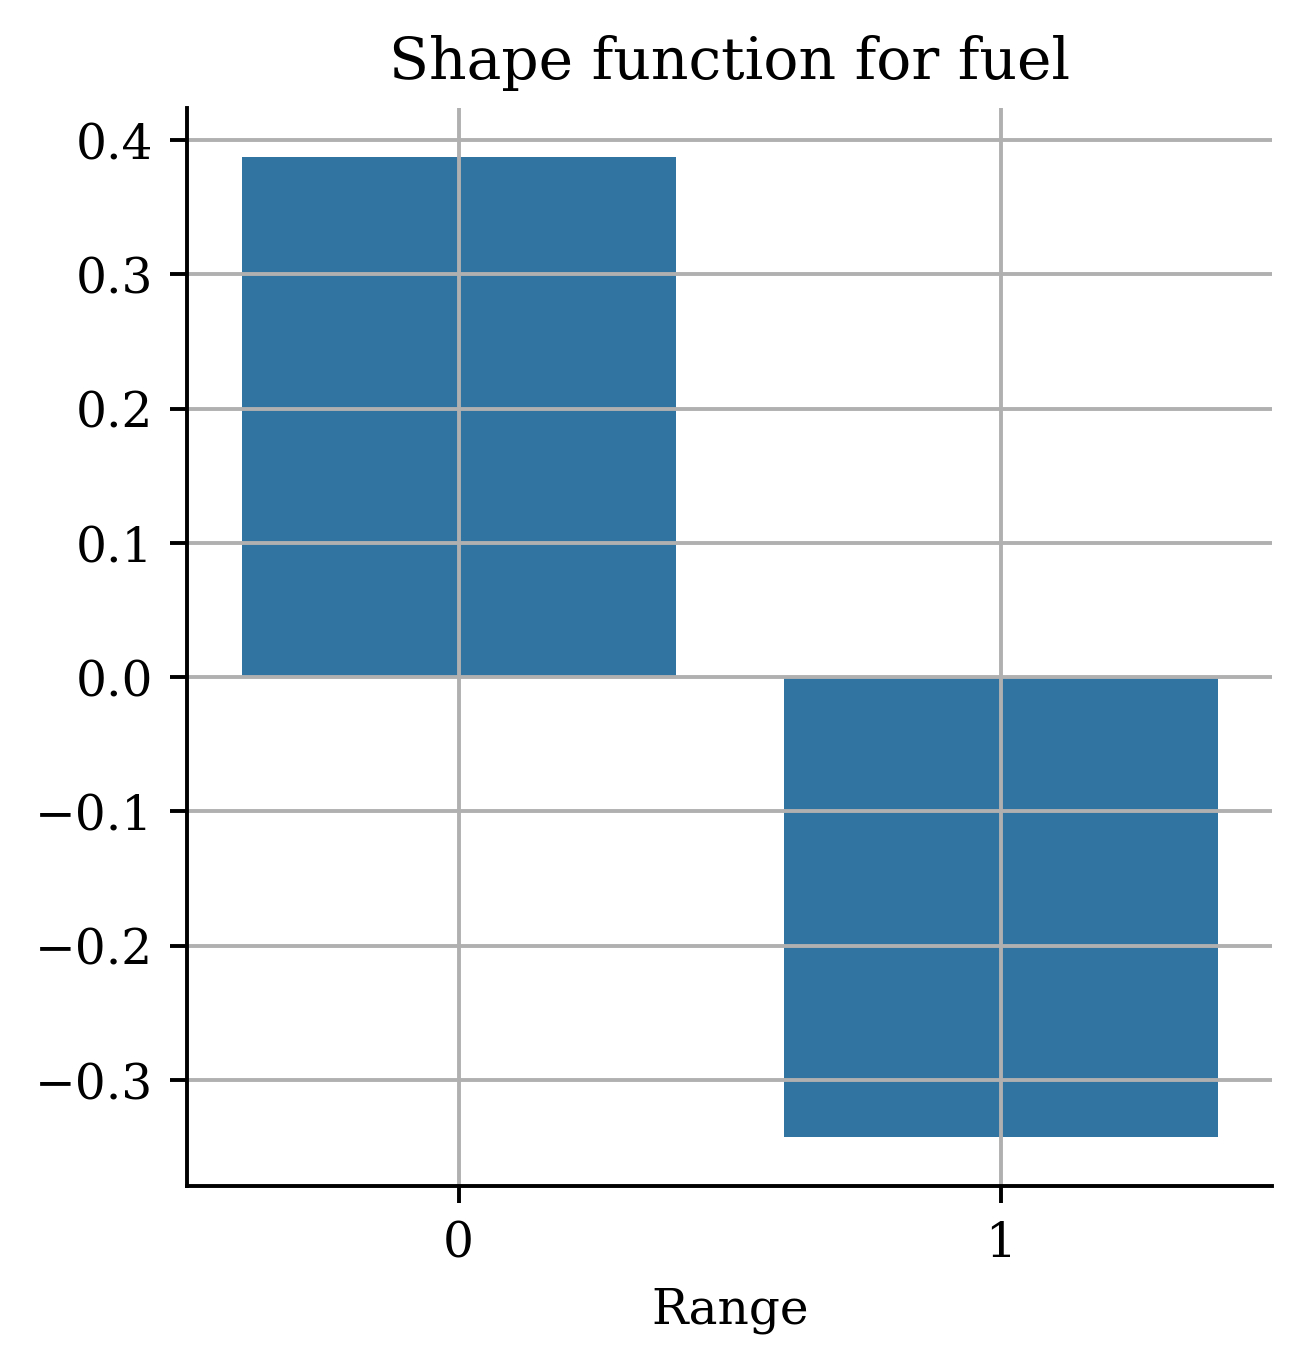

In [52]:
# -------------------------- View the Shape Function for Categorical Variable --------------------------
# Define the variable name and index
var_name = "fuel"
var_index = imp_vars.index(var_name)

# Prepare inputs for categorical values 0 and 1
grid_inputs_0 = []
grid_inputs_1 = []
for var in ["expo"] + imp_vars:
    if var == var_name:
        grid_inputs_0.append(np.zeros(1))  # fuel = 0
        grid_inputs_1.append(np.ones(1))   # fuel = 1
    else:
        grid_inputs_0.append(np.zeros(1))
        grid_inputs_1.append(np.zeros(1))

# Get predictions for fuel = 0 and fuel = 1
subnet_output_0 = subnet_model.predict(grid_inputs_0)
subnet_output_1 = subnet_model.predict(grid_inputs_1)

# Extract the subnetwork output for fuel
output_values = [subnet_output_0[0, var_index], subnet_output_1[0, var_index]]

# Plot the shape function
sns.barplot(x=[0, 1], y=output_values)
plt.xlabel(f"Range")
# plt.ylabel("Subnetwork Output")
plt.title(f"Shape function for {var_name}")
plt.grid(True)

# Plot settings
plt.rcParams["figure.figsize"] = (4, 4)  # For square figures
plt.rcParams["figure.dpi"] = 350
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.show()


20/20 [==============================] - 0s 4ms/step


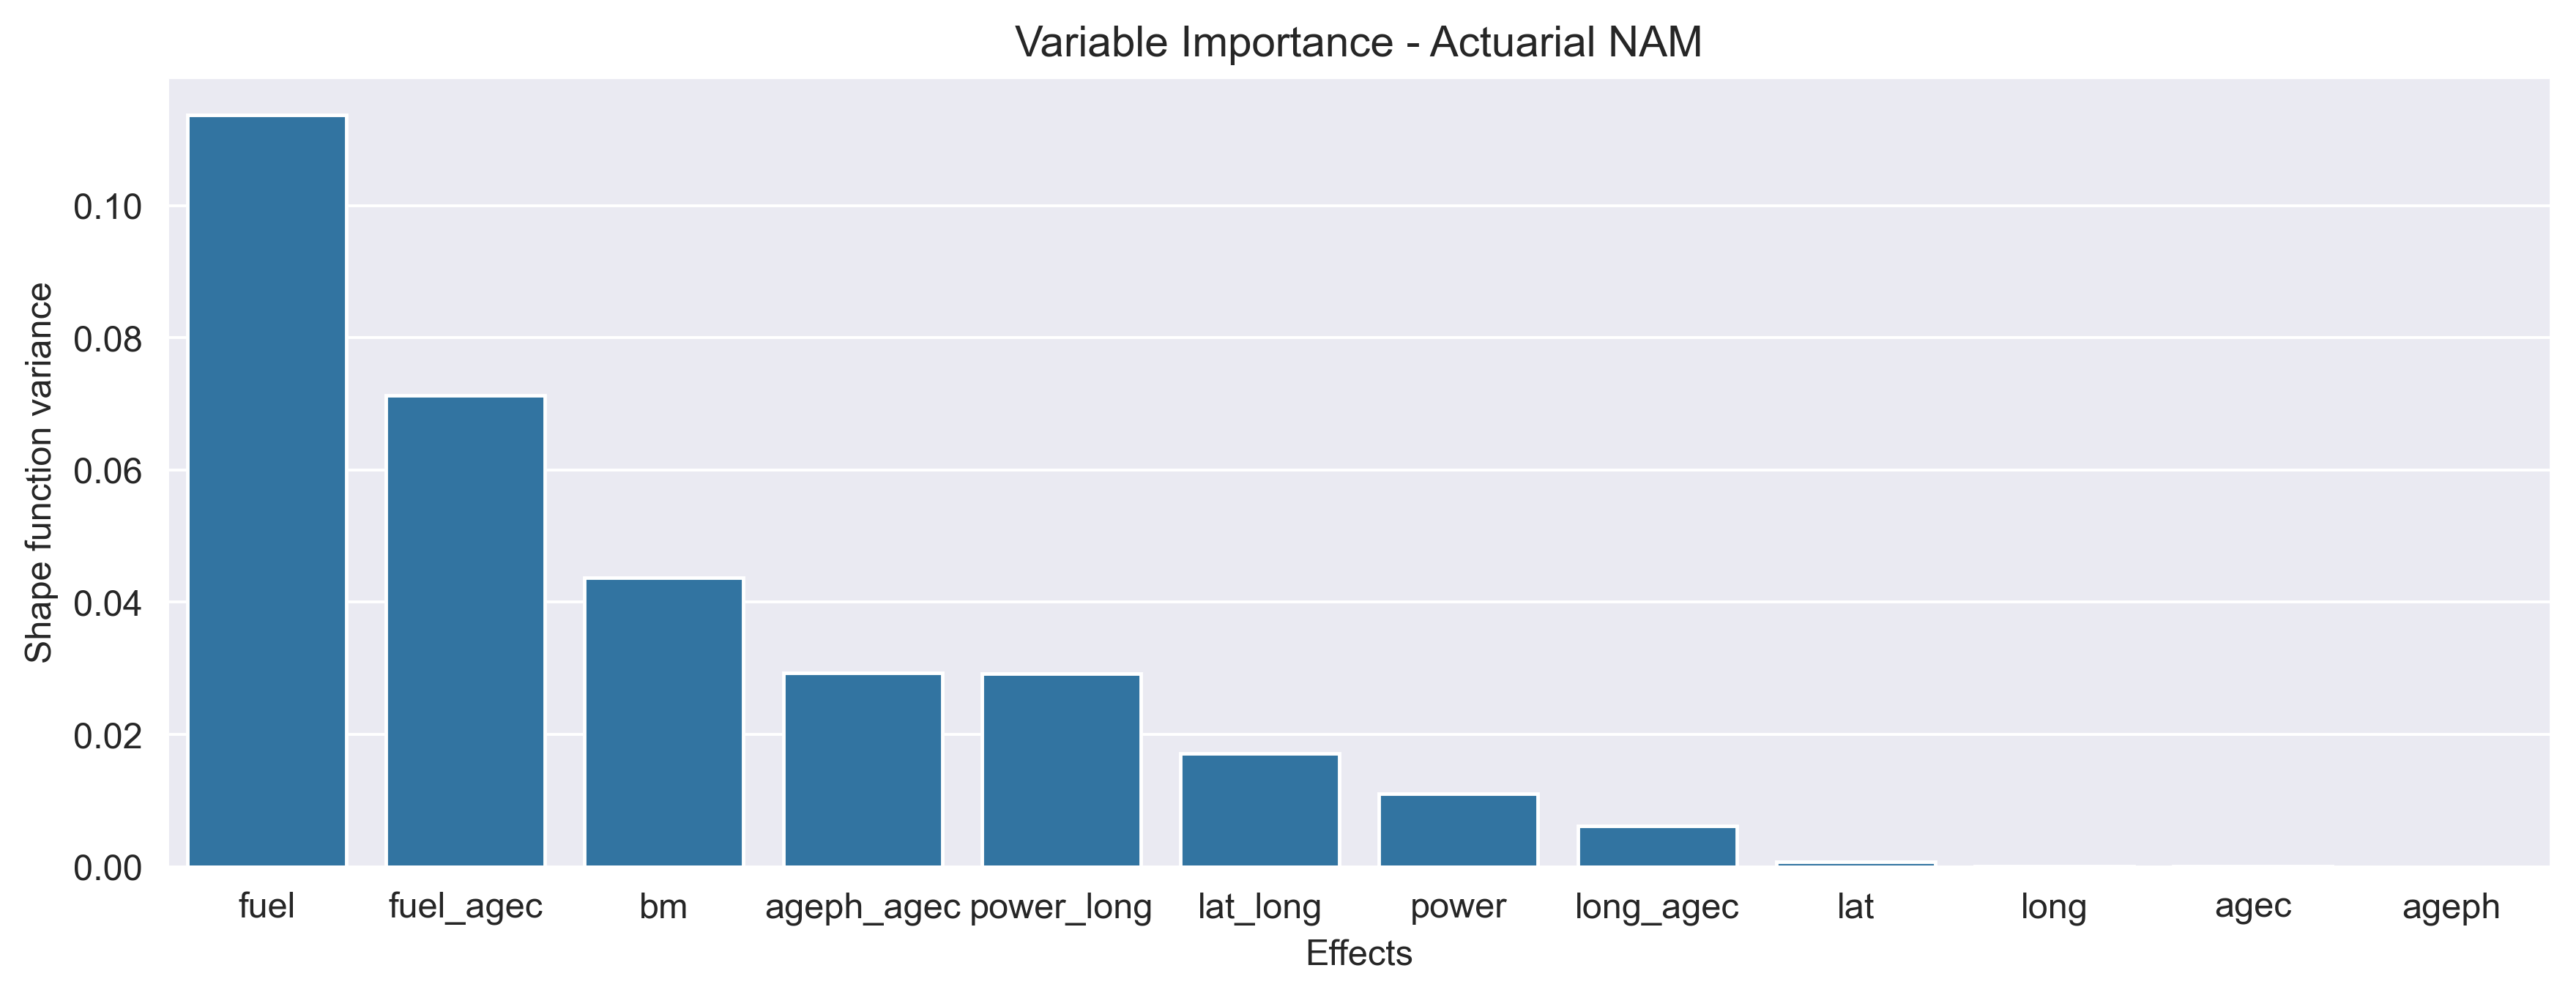

In [73]:
# -------------------------- quantify variable importance --------------------------
subnet_layer = model_nam.get_layer("subnet_output")
subnet_output_model = Model(inputs = model_nam.inputs, 
                            outputs = subnet_layer.output)
subnet_output_values = subnet_output_model.predict(X_train_split, batch_size = 5_000)
# subnet_weights = model_nam.get_layer("final_output").get_weights()[0]


# Get the variance of each subnetwork across all data points
subnet_variance = []
for i in range(subnet_output_values.shape[1]):
    # subnet_variance.append(np.var(subnet_output_values[:, i])*subnet_weights[i][0]**2)
    subnet_variance.append(np.var(subnet_output_values[:, i]))

# Define covariates
covariates = [name for name in imp_vars]
for i in range(len(interactions)):
    covariates.append(f"{interactions[i][0]}_{interactions[i][1]}")


# -------------------------- plot the variable importance --------------------------
# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": subnet_variance})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
# plt.figure(figsize = (10, 6))
sns.set_style("darkgrid")
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Variable Importance - Actuarial NAM")
plt.xlabel("Effects")
plt.ylabel("Shape function variance")

plt.rcParams["figure.figsize"] = (12.0, 4.0)
plt.rcParams["figure.dpi"] = 350
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.show()

In [ ]:
############################ EXPLAINABLE BOOSTING MACHINE ############################

# define monotonic constraints
monotone_constraint = []
for var in all_vars[1:]:
    if var == "bm":
        monotone_constraint.append(1)
    else:
        monotone_constraint.append(0)

In [36]:
# -------------------------- fit the model --------------------------
# load the model if already exists
ebm_name = "ebm_beMTPL97.joblib"
if os.path.exists(ebm_name):
    model_ebm = joblib.load(ebm_name)
    print(f"Model loaded from '{ebm_name}'")

else:
    # define the model
    ebm_reg = ExplainableBoostingRegressor(
        objective = "poisson_deviance",
        monotone_constraints = monotone_constraint,
        n_jobs = -1,
        random_state = 2024
    )

    # Define the hyperparameter grid
    param_grid = {
        'max_bins': [20, 50, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_leaves': [3, 10, 20, 50]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator = ebm_reg,
        param_grid = param_grid,
        scoring = 'neg_mean_poisson_deviance',
        n_jobs = -1
    )

    # Fit GridSearchCV
    grid_search.fit(train[:,1:], y_train/train[:,0])

    # Best parameters
    print("Best Hyperparameters:", grid_search.best_params_)

    # Model
    model_ebm = grid_search.best_estimator_

    joblib.dump(model_ebm, ebm_name)
    print(f"New model fitted and saved to '{ebm_name}'")

Model loaded from 'ebm_beMTPL97.joblib'


In [37]:
model_ebm.term_features_

[(0,),
 (1,),
 (2,),
 (3,),
 (4,),
 (5,),
 (6,),
 (7,),
 (8,),
 (9,),
 (10,),
 (5, 7),
 (5, 8),
 (5, 9),
 (5, 10),
 (7, 8),
 (7, 9),
 (7, 10),
 (8, 9),
 (8, 10),
 (9, 10)]

In [38]:
# -------------------------- evaluation --------------------------
ebm_pred = model_ebm.predict(test[:,1:]) # get the prediction

# get metrics on test data
ebm_nll = Poisson()(y_test, ebm_pred*test[:,0]).numpy()
ebm_rmse = np.sqrt(mse(y_test, ebm_pred*test[:,0]))
ebm_mae = mae(y_test, ebm_pred*test[:,0])
print(f"Poisson loss on test set: {ebm_nll}")
print(f"RMSE on test set: {ebm_rmse}")
print(f"MAE on test set: {ebm_mae}")

Poisson loss on test set: 0.38010991859611964
RMSE on test set: 0.3690886213660984
MAE on test set: 0.22500368421973316


In [39]:
np.where(ebm_pred > 0.8)

(array([ 2396, 11088, 21302, 23759, 25538]),)

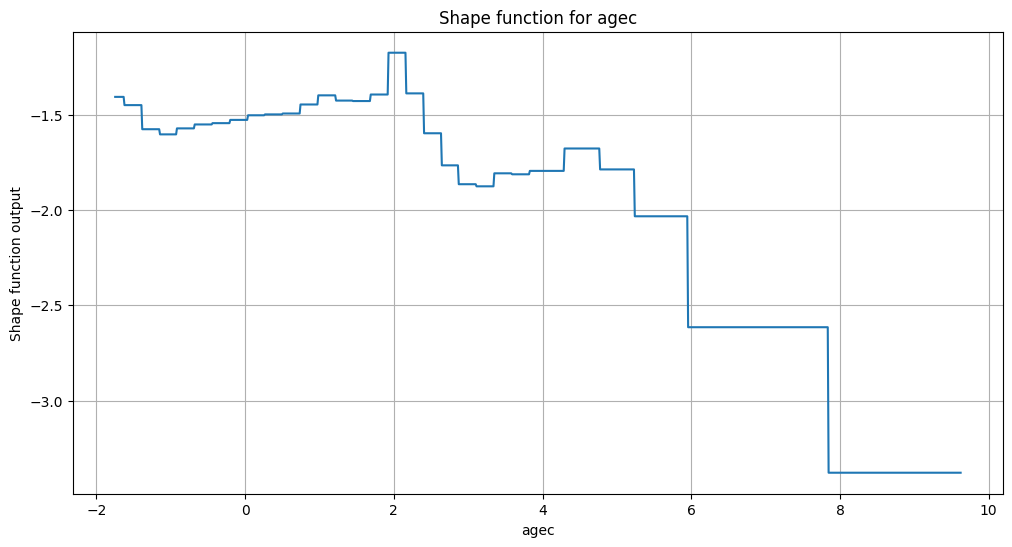

In [40]:
#-------------------------- view the shape function --------------------------
# generate input
var_name = "agec"
grid_length = 1000
grid = np.linspace(train[:,all_vars.index(var_name)].min(), 
                   train[:,all_vars.index(var_name)].max(), 
                   grid_length)
grid_inputs = []
for var in all_vars[1:]: # we don't consider exposure in the input data
    if var == var_name:
        grid_inputs.append(grid)
    else:
        grid_inputs.append(np.zeros_like(grid))
grid_inputs = np.column_stack(grid_inputs)

# get the prediction
output = np.log(model_ebm.predict(grid_inputs))

# create the plot
plt.figure(figsize = (12, 6))
sns.lineplot(x = grid, y = output)
plt.xlabel(f"{var_name}")
plt.ylabel('Shape function output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

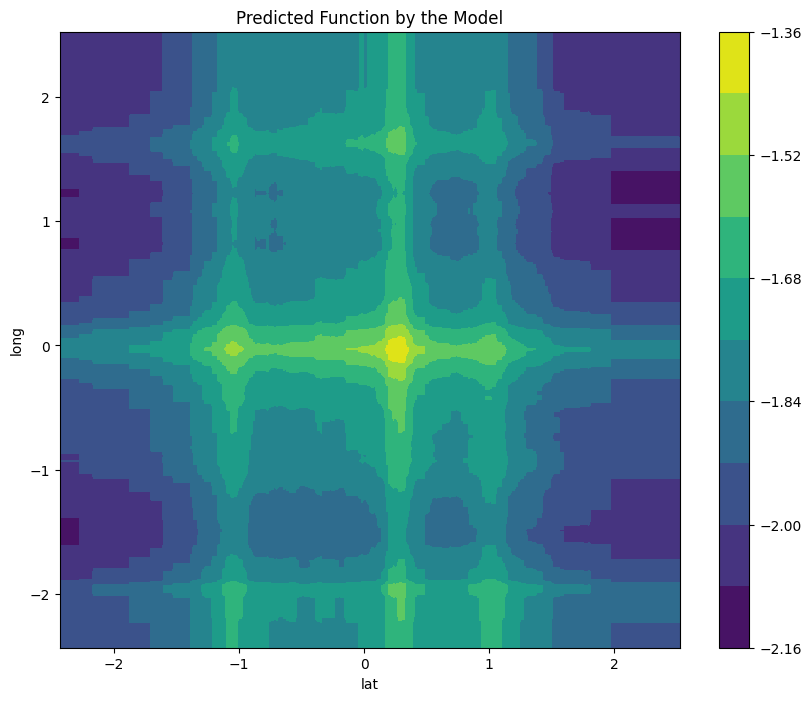

In [41]:
# -------------------------- View the heatmap --------------------------
pairwise_effect = ("lat", "long")  # the pairwise effect we want to view

# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 1000
if pairwise_effect[0] in cat_vars:
    var1_values = np.unique(train[:,all_vars.index(pairwise_effect[0])])
else:
    var1_values = np.linspace(train[:,all_vars.index(pairwise_effect[0])].min(),
                              train[:,all_vars.index(pairwise_effect[0])].max(),
                              grid_length)
if pairwise_effect[1] in cat_vars:
    var1_values = np.unique(train[:,all_vars.index(pairwise_effect[1])])
else:
    var1_values = np.linspace(train[:,all_vars.index(pairwise_effect[1])].min(),
                              train[:,all_vars.index(pairwise_effect[1])].max(),
                              grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
for var in all_vars[1:]:
    if var == pairwise_effect[0]:
        grid_inputs.append(grid_flat_var1)
    elif var == pairwise_effect[1]:
        grid_inputs.append(grid_flat_var2)
    else:
        grid_inputs.append(np.zeros_like(grid_flat_var1))
grid_inputs = np.column_stack(grid_inputs)


# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
pairwise_predictions = np.log(model_ebm.predict(grid_inputs))

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model')
plt.xlabel(f"{pairwise_effect[0]}")
plt.ylabel(f"{pairwise_effect[1]}")
plt.show()

In [42]:
############################ GAM ############################
# -------------------------- GAM with main effects only --------------------------
gam_name = "gam_beMTPL97.joblib"
if not os.path.exists(gam_name):
    # fit the model
    gam_main_model = PoissonGAM(
        f(0) +      
        f(1) +          
        f(2) +  
        f(3) +        
        f(4) +         
        s(5) +          
        s(6, constraints = 'monotonic_inc') +          
        s(7) +         
        s(8) +          
        s(9) +
        s(10),
        n_splines = 10      
    ).fit(train[:,1:], y_train/train[:,0])
    gam_main_model.summary()

In [43]:
# -------------------------- get the validation loss --------------------------
if not os.path.exists(gam_name):
    gam_main_pred = gam_main_model.predict(val[:,1:])
    gam_main_val_loss = Poisson()(y_val, gam_main_pred*val[:,0])
    print(f"Validation loss of GAM main effect model: {gam_main_val_loss}")

In [44]:
#-------------------------- train-test split --------------------------
gam_imp_vars = [var for var in all_vars[1:] if var != 'use']
X_train_gam = train[:,[var in gam_imp_vars for var in all_vars]]
X_val_gam = val[:,[var in gam_imp_vars for var in all_vars]]
X_test_gam = test[:,[var in gam_imp_vars for var in all_vars]]

In [45]:
# -------------------------- select pairwise interaction effects --------------------------
if not os.path.exists(gam_name):
    candidate_interactions = list(combinations(range(X_train_gam.shape[1]), 2)) # the last two variables have been identified as insignificant
    interaction_losses = {}

    # evaluate each pairwise interaction effect
    for interaction in candidate_interactions:

        # GAM with 1 pairwise interaction effect
        gam_pairwise_model = PoissonGAM(
            f(0) +  
            f(1) +      
            f(2) + 
            f(3) +          
            s(4) +        
            s(5, constraints = 'monotonic_inc') +       
            s(6) +          
            s(7) +       
            s(8) +
            s(9) +
            te(interaction[0], interaction[1]), # tensor product for interaction effect
            n_splines = 10
        )
        
        # fit the model
        gam_pairwise_model.fit(X_train_gam, y_train/train[:,0])
        
        # Calculate validation loss
        gam_pairwise_pred = gam_pairwise_model.predict(X_val_gam)
        gam_pairwise_val_loss = Poisson()(y_val, gam_pairwise_pred*val[:,0])
        interaction_losses[f"{interaction[0]}_{interaction[1]}"] = gam_pairwise_val_loss

In [46]:
# -------------------------- plot the validation loss --------------------------
if not os.path.exists(gam_name):
    # Convert interaction loss dictionary to a pandas DataFrame
    interaction_df = pd.DataFrame(list(interaction_losses.items()), columns = ['Interaction_Pair', 'Validation_Loss'])
    interaction_df['Validation_Loss'] = interaction_df['Validation_Loss'].apply(lambda x: x.numpy())

    # Sort the DataFrame by Validation_Loss in increasing order
    interaction_df = interaction_df.sort_values(by = 'Validation_Loss', ascending = True)
    interaction_df = interaction_df.head(30)

    # Create the bar plot using Seaborn
    plt.figure(figsize = (16, 8))
    sns.lineplot(x = 'Interaction_Pair', y = 'Validation_Loss', data = interaction_df, marker = 'o')
    plt.axhline(gam_main_val_loss, color = 'red', linestyle = '--', label = 'Validation Loss of Main Effect Model')
    plt.xlabel('Interaction Effect Pairs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss for Interaction Effect Pairs (Sorted by Increasing Loss)')
    plt.legend()
    plt.show()

In [47]:
# -------------------------- define and fit the GAM model --------------------------
if os.path.exists(gam_name):
    model_gam = joblib.load(gam_name)
    print(f"Model loaded from '{gam_name}'")
else:
    model_gam = PoissonGAM(
            f(0) +  
            f(1) +      
            f(2) + 
            f(3) +          
            s(4) +        
            s(5, constraints = 'monotonic_inc') +       
            s(6) +          
            s(7) +       
            s(8) +
            s(9) +
            s(6, by = 1) +
            s(6, by = 2) +
            s(7, by = 2)
    )

    # -------------------------- define hyperparameter for tuning --------------------------
    # Define the hyperparameter grid
    lam_values = [0.001, 0.01, 0.1, 1]
    n_splines_values = [5, 10, 20, 30]


    # -------------------------- # Perform gridsearch --------------------------
    model_gam.gridsearch(X_train_gam, y_train/train[:,0], lam = lam_values, n_splines = n_splines_values)
    joblib.dump(model_gam, gam_name)
    print(f"New model fitted and saved to '{model_gam}'")
    
    # view the optimal hyperparameters
    print(f"Smoothness penalty: {model_gam.lam}")
    print(f"Number of splines: {model_gam.n_splines}")

Model loaded from 'gam_beMTPL97.joblib'


In [48]:
# -------------------------- evaluation --------------------------
gam_pred = model_gam.predict(X_test_gam) # get the prediction

# get metrics on test data
gam_nll = Poisson()(y_test, gam_pred*test[:,0]).numpy()
gam_rmse = np.sqrt(mse(y_test, gam_pred*test[:,0]))
gam_mae = mae(y_test, gam_pred*test[:,0])
print(f"Poisson loss on test set: {gam_nll}")
print(f"RMSE on test set: {gam_rmse}")
print(f"MAE on test set: {gam_mae}")

Poisson loss on test set: 0.38242690127563883
RMSE on test set: 0.37118285679624385
MAE on test set: 0.22471619273969304


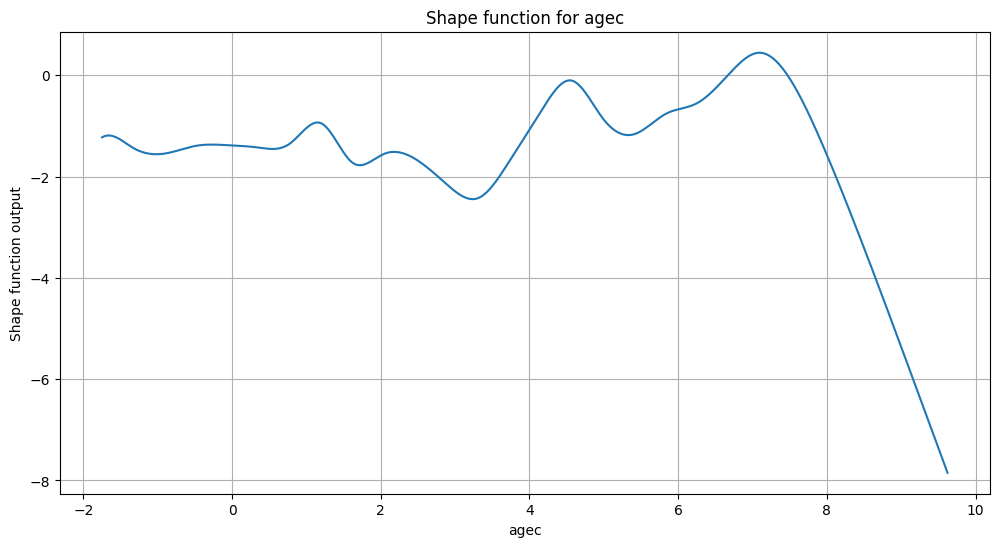

In [49]:
#-------------------------- view the shape function --------------------------
# generate input
var_name = "agec"
grid_length = 1000
grid = np.linspace(X_train_gam[:,gam_imp_vars.index(var_name)].min(), 
                   X_train_gam[:,gam_imp_vars.index(var_name)].max(), 
                   grid_length)
grid_inputs = []
for var in gam_imp_vars: # we don't consider exposure in the input data
    if var == var_name:
        grid_inputs.append(grid)
    else:
        grid_inputs.append(np.zeros_like(grid))
grid_inputs = np.column_stack(grid_inputs)

# get the prediction
output = np.log(model_gam.predict(grid_inputs))

# create the plot
plt.figure(figsize = (12, 6))
sns.lineplot(x = grid, y = output)
plt.xlabel(f"{var_name}")
plt.ylabel('Shape function output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

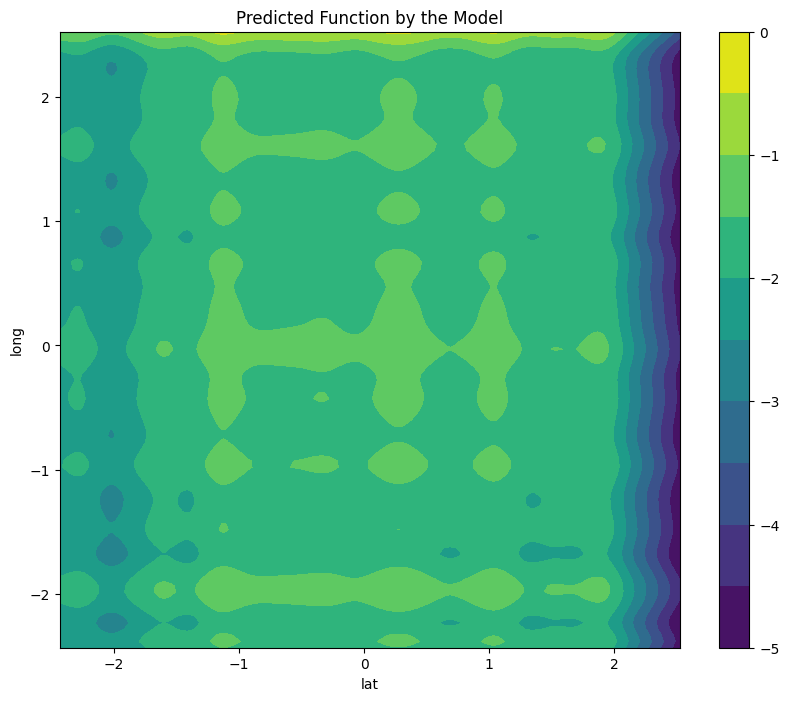

In [50]:
# -------------------------- View the heatmap --------------------------
pairwise_effect = ("lat", "long")  # the pairwise effect we want to view

# -------------------------- Generate the Input Grid --------------------------
# Create a grid of values
grid_length = 1000
if pairwise_effect[0] in cat_vars:
    var1_values = np.unique(train[:,all_vars.index(pairwise_effect[0])])
else:
    var1_values = np.linspace(train[:,all_vars.index(pairwise_effect[0])].min(),
                              train[:,all_vars.index(pairwise_effect[0])].max(),
                              grid_length)
if pairwise_effect[1] in cat_vars:
    var1_values = np.unique(train[:,all_vars.index(pairwise_effect[1])])
else:
    var1_values = np.linspace(train[:,all_vars.index(pairwise_effect[1])].min(),
                              train[:,all_vars.index(pairwise_effect[1])].max(),
                              grid_length)

# Create a meshgrid
grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# Flatten the grid
grid_flat_var1 = grid_var1.ravel()
grid_flat_var2 = grid_var2.ravel()


# -------------------------- Prepare Inputs for the Model --------------------------
grid_inputs = []
for var in gam_imp_vars:
    if var == pairwise_effect[0]:
        grid_inputs.append(grid_flat_var1)
    elif var == pairwise_effect[1]:
        grid_inputs.append(grid_flat_var2)
    else:
        grid_inputs.append(np.zeros_like(grid_flat_var1))
grid_inputs = np.column_stack(grid_inputs)


# -------------------------- Predict Using the Pairwise-Only Model --------------------------
# Predict the pairwise interaction effect
pairwise_predictions = np.log(model_gam.predict(grid_inputs))

# Reshape the predictions to the grid format
heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# -------------------------- Plot the Heatmap --------------------------
plt.figure(figsize = (10, 8))
contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
plt.colorbar(contour)
plt.title('Predicted Function by the Model')
plt.xlabel(f"{pairwise_effect[0]}")
plt.ylabel(f"{pairwise_effect[1]}")
plt.show()

In [51]:
############################ NEURAL NETS ############################

#-------------------------- define the neural network architecture--------------------------
def build_NN(hp):

    # tuning hyperparameters
    num_layers = hp.Int('num_dense_layers', 5, 20, step = 3) # number of hidden layers
    num_neurons = hp.Int(f'num_neurons_first_hidden', 50, 500, step = 50) # number of neurons in the first hidden layers
    dropout_rate = hp.Float(f'dropout_rate', min_value = 0.1, max_value = 0.4, step = 0.1) # dropout rate
    lr = hp.Float('learning_rate', min_value = 1e-5, max_value = 1e-3, sampling = 'log') # learning rate
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'softplus', 'swish'])

    # architecture
    input_layer = Input((train.shape[1] - 1,))
    x = input_layer
    for i in range(num_layers):
        num_units = num_neurons - i*int(num_neurons/num_layers)
        x = Dense(units = num_units, activation = activation)(x)
        x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation = "exponential")(x)
    exposure_input = Input(shape = (1,), name = "exposure") # for exposure
    final_output = Multiply(name = "final_output")([exposure_input, output_layer])

        # model
    model = Model(inputs = [exposure_input] + [input_layer], outputs = final_output)
    
    # build model
    model.compile(optimizer = RMSprop(learning_rate = lr),
            loss = 'poisson',
            metrics = ['poisson', RootMeanSquaredError(), MeanAbsoluteError()])
    
    return model

In [52]:
# -------------------------- hyperparameters of final model --------------------------
# hyperparameter tuning
tuner_NN = kt.tuners.BayesianOptimization(
    build_NN,
    objective = kt.Objective('val_poisson', direction = 'min'),
    max_trials = 20,
    directory = "hyperparameter_beMTPL97_NN",
    seed = 0 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 40, restore_best_weights = True)

# search for the best model
tuner_NN.search([train[:,0],train[:,1:]], y_train,
            epochs = 5_000,
            batch_size = 10_000,
            validation_data = ([val[:,0],val[:,1:]], y_val),
            callbacks = [es])

# get the best model
model_nn = tuner_NN.get_best_models()[0]
tuner_NN.results_summary(1)

Reloading Tuner from hyperparameter_beMTPL97_NN/untitled_project/tuner0.json
Results summary
Results in hyperparameter_beMTPL97_NN/untitled_project
Showing 1 best trials
Objective(name="val_poisson", direction="min")

Trial 01 summary
Hyperparameters:
num_dense_layers: 5
num_neurons_first_hidden: 200
dropout_rate: 0.2
learning_rate: 0.00046594382665991296
activation: leaky_relu
Score: 0.3695557713508606


In [53]:
#-------------------------- evaluate predictive performance --------------------------
_, nn_nll, nn_rmse, nn_mae = model_nn.evaluate([test[:,0], test[:,1:]], y_test, batch_size = 5_000)
print(f"Poisson loss on test set: {nn_nll}")
print(f"RMSE on test set: {nn_rmse}")
print(f"MAE on test set: {nn_mae}")

7/7 [==============================] - 0s 7ms/step - loss: 0.3794 - poisson: 0.3794 - root_mean_squared_error: 0.3682 - mean_absolute_error: 0.2195
Poisson loss on test set: 0.37936389446258545
RMSE on test set: 0.3681735396385193
MAE on test set: 0.21950650215148926


In [54]:
############################ GLM ############################
# -------------------------- data prep --------------------------
# get the exposure
expo_train = train[:, 0]
expo_test = test[:, 0]

# add intercept terms
train_GLM = sm.add_constant(train[:,1:])
test_GLM = sm.add_constant(test[:,1:])

# -------------------------- fit a GLM with Gaussian distribution --------------------------
model = sm.GLM(y_train, train_GLM, family = sm.families.Poisson(sm.families.links.log()), offset = np.log(expo_train))
model_glm = model.fit()

# get model summary
print(model_glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                nclaims   No. Observations:                97926
Model:                            GLM   Df Residuals:                    97914
Model Family:                 Poisson   Df Model:                           11
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -37419.
Date:                Fri, 08 Nov 2024   Deviance:                       52291.
Time:                        23:36:03   Pearson chi2:                 1.14e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.01581
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8482      0.025    -73.014      0.0

In [55]:
# -------------------------- evaluation --------------------------
glm_pred = model_glm.predict(test_GLM, offset = np.log(expo_test)) # get the prediction

# get metrics on test data
glm_nll = Poisson()(y_test, glm_pred).numpy()
glm_rmse = np.sqrt(mse(y_test, glm_pred))
glm_mae = mae(y_test, glm_pred)
print(f"Poisson loss on test set: {glm_nll}")
print(f"RMSE on test set: {glm_rmse}")
print(f"MAE on test set: {glm_mae}")

Poisson loss on test set: 0.3803408150566882
RMSE on test set: 0.36854390010665344
MAE on test set: 0.21737028648957685


In [56]:
############################ LocalGLMnet ############################
#-------------------------- define model architecture --------------------------
def build_LGLMNet(hp):

    # tuning hyperparameters
    num_layers = hp.Int('num_dense_layers', 4, 10, step = 1) # number of hidden layers
    num_neurons = hp.Int(f'num_neurons', 50, 200, step = 40) # number of neurons per hidden layer
    dropout_rate = hp.Float(f'dropout_rate', min_value = 0, max_value = 0.3, step = 0.1) # dropout rate
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log') # learning rate
    activation = hp.Choice('activation', ['relu', 'leaky_relu', 'softplus', 'swish'])

    # neural network
    attention_outputs = []
    input_layer = Input((train.shape[1] - 1,), name = "input_layer")

    for var in all_vars[1:]:
        # get the corresponding input
        var_index = all_vars.index(var) - 1
        var_input = input_layer[:,var_index:var_index+1]

        # create the attention
        x = input_layer
        for i in range(num_layers):
            x = Dense(units = num_neurons, activation = activation)(x)
            x = Dropout(dropout_rate)(x)
        attention_layer = Dense(1, activation = "linear")(x)
        attention_output = Multiply()([var_input, attention_layer])
        attention_outputs.append(attention_output)

    # add the output of each network
    concat_layer = Concatenate()(attention_outputs)
    output_layer = Dense(1, activation = "exponential", name = "output_layer")(concat_layer)
    exposure_input = Input(shape = (1,)) # for exposure
    final_output = Multiply(name = "final_output")([exposure_input, output_layer])

    # model
    model = Model(inputs = [exposure_input, input_layer], outputs = final_output)
    
    # build model
    model.compile(optimizer = RMSprop(learning_rate = lr),
            loss = 'poisson',
            metrics = [RootMeanSquaredError(), MeanAbsoluteError()])
    
    return model

In [57]:
# -------------------------- tune and fit the model --------------------------
# tuner
tuner_lglm = kt.BayesianOptimization(
    build_LGLMNet,
    objective = 'val_loss',
    max_trials = 20,
    directory = "hyperparameter_beMTPL97_lglm",
    seed = 2024 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 50, restore_best_weights = True, verbose = 0)

# search for the best model
tuner_lglm.search([train[:,0],train[:,1:]], y_train,
        epochs = 5_000,
        batch_size = 10_000,
        validation_data = ([val[:,0],val[:,1:]], y_val),
        callbacks = [es])

# get the best model
model_lglm = tuner_lglm.get_best_models()[0]
tuner_lglm.results_summary(1)

Reloading Tuner from hyperparameter_beMTPL97_lglm/untitled_project/tuner0.json
Results summary
Results in hyperparameter_beMTPL97_lglm/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 12 summary
Hyperparameters:
num_dense_layers: 7
num_neurons: 50
dropout_rate: 0.1
learning_rate: 0.00018060072463857053
activation: softplus
Score: 0.36987337470054626


In [58]:
#-------------------------- evaluate predictive performance --------------------------
lglm_nll, lglm_rmse, lglm_mae = model_lglm.evaluate([test[:,0], test[:,1:]], y_test, batch_size = 5_000)
print(f"Poisson loss on test set: {lglm_nll}")
print(f"RMSE on test set: {lglm_rmse}")
print(f"MAE on test set: {lglm_mae}")

7/7 [==============================] - 1s 36ms/step - loss: 0.3795 - root_mean_squared_error: 0.3681 - mean_absolute_error: 0.2200
Poisson loss on test set: 0.3795410394668579
RMSE on test set: 0.36812442541122437
MAE on test set: 0.21998751163482666


In [59]:
gbm_nll = 0.3798
gbm_rmse = 0.37056
gbm_mae = 0.22443

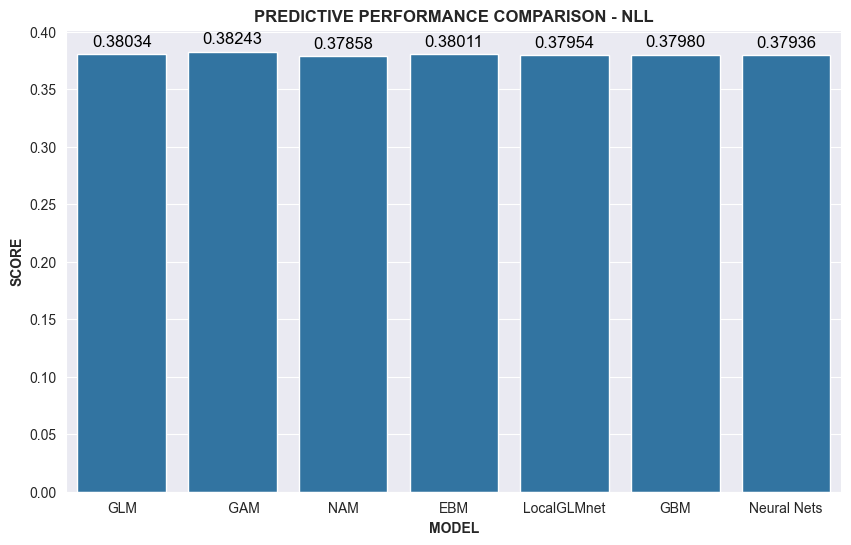

In [60]:
# create a DataFrame with the predictive scores
df_performance = {
    'Model': ['GLM',
        '      GAM',
              'NAM',
              'EBM',
              'LocalGLMnet',
              'GBM',
              'Neural Nets'],
    'Gamma NLL': [glm_nll,
                gam_nll,
                nam_nll,
                ebm_nll,
                lglm_nll,
                gbm_nll,
                nn_nll]
}
df_performance = pd.DataFrame(df_performance)

# set the aesthetic style of the plots
sns.set_style("darkgrid")

# create a barplot
plt.figure(figsize = (10, 6))
barplot = sns.barplot(x = 'Model', y = 'Gamma NLL', data = df_performance)


# add value labels on top of each bar
for p in barplot.patches:
    value = p.get_height()
    if value != 0:
        barplot.annotate(format(value, '.5f'), 
                         (p.get_x() + p.get_width() / 2., value), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points',
                         fontsize = 12, color = 'black')


# set the title and labels
barplot.set_title('PREDICTIVE PERFORMANCE COMPARISON - NLL', fontsize = 12, fontweight = 'bold')
barplot.set_xlabel('MODEL', fontsize = 10, fontweight = 'bold')
barplot.set_ylabel('SCORE', fontsize = 10, fontweight = 'bold')

# size of x-label
barplot.tick_params(labelsize = 10)

# Show the plot
plt.show()

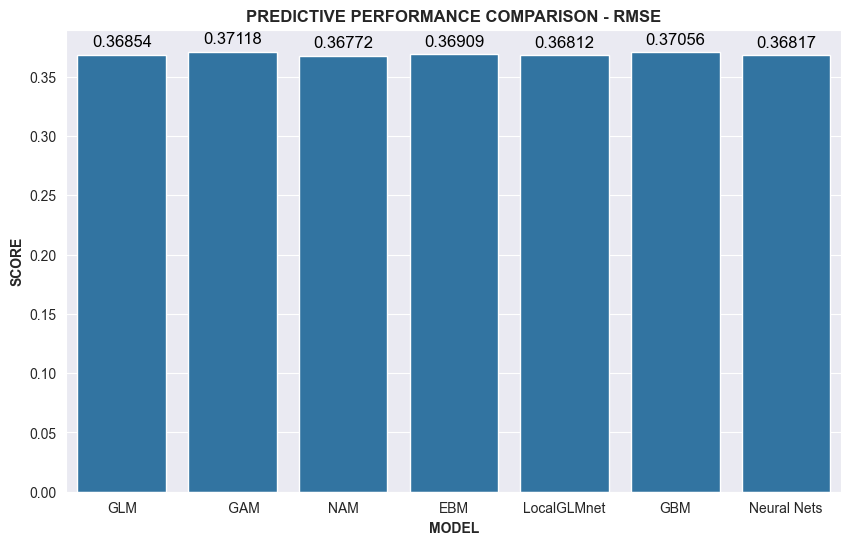

In [61]:
# create a DataFrame with the predictive scores
df_performance = {
    'Model': ['GLM',
        '      GAM',
              'NAM',
              'EBM',
              'LocalGLMnet',
              'GBM',
              'Neural Nets'],
    'Gamma RMSE': [glm_rmse,
                gam_rmse,
                nam_rmse,
                ebm_rmse,
                lglm_rmse,
                gbm_rmse,
                nn_rmse]
}
df_performance = pd.DataFrame(df_performance)

# set the aesthetic style of the plots
sns.set_style("darkgrid")

# create a barplot
plt.figure(figsize = (10, 6))
barplot = sns.barplot(x = 'Model', y = 'Gamma RMSE', data = df_performance)


# add value labels on top of each bar
for p in barplot.patches:
    value = p.get_height()
    if value != 0:
        barplot.annotate(format(value, '.5f'), 
                         (p.get_x() + p.get_width() / 2., value), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points',
                         fontsize = 12, color = 'black')


# set the title and labels
barplot.set_title('PREDICTIVE PERFORMANCE COMPARISON - RMSE', fontsize = 12, fontweight = 'bold')
barplot.set_xlabel('MODEL', fontsize = 10, fontweight = 'bold')
barplot.set_ylabel('SCORE', fontsize = 10, fontweight = 'bold')

# size of x-label
barplot.tick_params(labelsize = 10)

# Show the plot
plt.show()

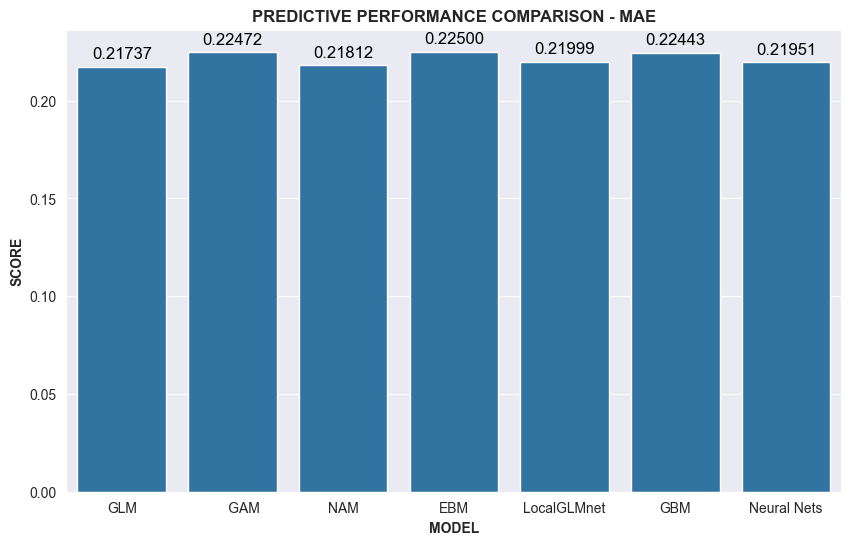

In [62]:
# create a DataFrame with the predictive scores
df_performance = {
    'Model': ['GLM',
        '      GAM',
              'NAM',
              'EBM',
              'LocalGLMnet',
              'GBM',
              'Neural Nets'],
    'Gamma MAE': [glm_mae,
                gam_mae,
                nam_mae,
                ebm_mae,
                lglm_mae,
                gbm_mae,
                nn_mae]
}
df_performance = pd.DataFrame(df_performance)

# set the aesthetic style of the plots
sns.set_style("darkgrid")

# create a barplot
plt.figure(figsize = (10, 6))
barplot = sns.barplot(x = 'Model', y = 'Gamma MAE', data = df_performance)


# add value labels on top of each bar
for p in barplot.patches:
    value = p.get_height()
    if value != 0:
        barplot.annotate(format(value, '.5f'), 
                         (p.get_x() + p.get_width() / 2., value), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points',
                         fontsize = 12, color = 'black')


# set the title and labels
barplot.set_title('PREDICTIVE PERFORMANCE COMPARISON - MAE', fontsize = 12, fontweight = 'bold')
barplot.set_xlabel('MODEL', fontsize = 10, fontweight = 'bold')
barplot.set_ylabel('SCORE', fontsize = 10, fontweight = 'bold')

# size of x-label
barplot.tick_params(labelsize = 10)

# Show the plot
plt.show()